# Libraries

In [3]:
import os
import wandb
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import sys
import torch.optim as optim
import albumentations as A
from tqdm import tqdm
batch_size = 24
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
import copy
from timm.models import create_model
from timm.models.helpers import build_model_with_cfg
from timm.models.registry import register_model
import xml.etree.ElementTree as ET
from tqdm import tqdm
import torchvision.transforms as T
import timm
import os
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import re
from collections import Counter
from torch import nn

/usr/local/lib/python3.11/dist-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


# EDA

In [4]:
root_voc = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val"
batch_size = 24

In [5]:
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

class_to_idx = {cls_name: i for i, cls_name in enumerate(VOC_CLASSES)}

In [6]:
def extract_classes_from_annotation_regex(name_str, voc_classes):
    s = name_str.strip().lower()
    sorted_classes = sorted(voc_classes, key=lambda x: -len(x))
    pattern = re.compile("|".join(sorted_classes))
    matches = pattern.findall(s)
    unique_matches = []
    for m in matches:
        if m not in unique_matches:
            unique_matches.append(m)
    return unique_matches

In [7]:
class PascalVOCDataset(Dataset):
    def __init__(self, root, image_set="train", transform=None):
        super().__init__()
        self.root = root
        self.transform = transform
        if image_set == "train":
            file_list = os.path.join(root, "ImageSets", "Segmentation", "train.txt")
        elif image_set == "val":
            file_list = os.path.join(root, "ImageSets", "Segmentation", "val.txt")
        else:
            file_list = os.path.join(root, "ImageSets", "Segmentation", f"{image_set}.txt")
        with open(file_list, "r") as f:
            self.image_ids = [line.strip() for line in f if line.strip()]
        
        self.samples = []
        for image_id in self.image_ids:
            ann_path = os.path.join(root, "Annotations", image_id + ".xml")
            try:
                tree = ET.parse(ann_path)
                root_xml = tree.getroot()
            except Exception as e:
                print(f"Error parsing {ann_path}: {e}")
                continue
            objects = root_xml.findall("object")
            classes_in_image = set()
            for obj in objects:
                name_str = obj.find("name").text
                extracted = extract_classes_from_annotation_regex(name_str, VOC_CLASSES)
                for cls in extracted:
                    classes_in_image.add(cls)
            for cls in classes_in_image:
                self.samples.append((image_id, cls))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        image_id, cls = self.samples[index]
        img_path = os.path.join(self.root, "JPEGImages", image_id + ".jpg")
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)
        label = class_to_idx[cls]
        return image, label

In [8]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])  
])
    
train_dataset = PascalVOCDataset(root=root_voc, image_set="train", transform=transform)
val_dataset   = PascalVOCDataset(root=root_voc, image_set="val", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [9]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

In [10]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image

def get_all_labels_from_xml(image_id, ann_dir, voc_classes):
    xml_path = os.path.join(ann_dir, f"{image_id}.xml")
    try:
        tree = ET.parse(xml_path)
        root_xml = tree.getroot()
        labels = set()
        for obj in root_xml.findall("object"):
            cls = obj.find("name").text.lower().strip()
            if cls in voc_classes:
                labels.add(cls)
        return list(labels)
    except Exception as e:
        print(f"Error: {e} for {image_id}")
        return []

root_voc = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val"
img_dir = os.path.join(root_voc, "JPEGImages")
ann_dir = os.path.join(root_voc, "Annotations")

# Training

In [11]:
def train_model(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    criterion, 
    device, 
    epochs=10, 
    scheduler=None,
    return_best=True,
    save_best_path=None
):
    model = model.to(device)
    best_acc = 0
    best_model_wts = None
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
        
        train_loss_epoch = train_loss / train_total
        train_acc_epoch = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_loss_epoch = val_loss / val_total
        val_acc_epoch = val_correct / val_total

        history['train_loss'].append(train_loss_epoch)
        history['val_loss'].append(val_loss_epoch)
        history['train_acc'].append(train_acc_epoch)
        history['val_acc'].append(val_acc_epoch)

        # Save best model by val acc
        if val_acc_epoch > best_acc:
            best_acc = val_acc_epoch
            if return_best:
                best_model_wts = model.state_dict()
            if save_best_path:
                # Save checkpoint (avoid overwrite by adding epoch/acc if needed)
                torch.save(model.state_dict(), save_best_path)
        
        if scheduler is not None:
            scheduler.step(val_loss_epoch)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss_epoch:.4f} Acc: {train_acc_epoch:.4f} | "
              f"Val Loss: {val_loss_epoch:.4f} Acc: {val_acc_epoch:.4f}")

    # Load best weights
    if return_best and best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    return model, history

## CROPPING

In [12]:
output_dir = "./cropped"
os.makedirs(output_dir, exist_ok=True)
img_dir = os.path.join(root_voc, "JPEGImages")
ann_dir = os.path.join(root_voc, "Annotations")


def extract_crops_from_voc(image_set="train", resize=(224,224), max_per_class=None):
    file_list = os.path.join(root_voc, "ImageSets", "Segmentation", f"{image_set}.txt")
    with open(file_list, "r") as f:
        image_ids = [line.strip() for line in f if line.strip()]
    counter = {cls: 0 for cls in VOC_CLASSES}
    for image_id in image_ids:
        img_path = os.path.join(img_dir, f"{image_id}.jpg")
        ann_path = os.path.join(ann_dir, f"{image_id}.xml")
        if not os.path.exists(img_path) or not os.path.exists(ann_path):
            continue
        try:
            image = Image.open(img_path).convert("RGB")
            tree = ET.parse(ann_path)
            root_xml = tree.getroot()
        except Exception as e:
            print(f"Error processing {image_id}: {e}")
            continue
        for obj in root_xml.findall("object"):
            cls_name = obj.find("name").text.lower().strip()
            if cls_name not in VOC_CLASSES:
                continue
            if max_per_class is not None and counter[cls_name] >= max_per_class:
                continue
            bbox = obj.find("bndbox")
            xmin = int(float(bbox.find("xmin").text))
            ymin = int(float(bbox.find("ymin").text))
            xmax = int(float(bbox.find("xmax").text))
            ymax = int(float(bbox.find("ymax").text))
            if xmax - xmin < 16 or ymax - ymin < 16:
                continue
            crop = image.crop((xmin, ymin, xmax, ymax))
            crop = crop.resize(resize)
            cls_dir = os.path.join(output_dir, cls_name)
            os.makedirs(cls_dir, exist_ok=True)
            crop_path = os.path.join(cls_dir, f"{image_id}_{counter[cls_name]:04d}.jpg")
            if os.path.exists(crop_path):
                print(f"File exists, skipping: {crop_path}")
                continue
            crop.save(crop_path)
            counter[cls_name] += 1
    print(f"Crops for '{image_set}' saved in: {output_dir}")
    for cls in VOC_CLASSES:
        print(f"{cls:12s}: {counter[cls]} images")

In [14]:
extract_crops_from_voc("train", resize=(224,224))
extract_crops_from_voc("val", resize=(224,224))

Crops for 'train' saved in: ./cropped
aeroplane   : 104 images
bicycle     : 90 images
bird        : 133 images
boat        : 118 images
bottle      : 163 images
bus         : 118 images
car         : 188 images
cat         : 154 images
chair       : 302 images
cow         : 145 images
diningtable : 86 images
dog         : 149 images
horse       : 100 images
motorbike   : 101 images
person      : 812 images
pottedplant : 148 images
sheep       : 149 images
sofa        : 103 images
train       : 96 images
tvmonitor   : 101 images
Crops for 'val' saved in: ./cropped
aeroplane   : 110 images
bicycle     : 101 images
bird        : 137 images
boat        : 104 images
bottle      : 146 images
bus         : 113 images
car         : 214 images
cat         : 132 images
chair       : 245 images
cow         : 132 images
diningtable : 82 images
dog         : 150 images
horse       : 104 images
motorbike   : 103 images
person      : 808 images
pottedplant : 164 images
sheep       : 137 images
sofa 

In [13]:
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
cropped_dataset = ImageFolder(root="./cropped", transform=transform)
class_names = cropped_dataset.classes

print(f"Total images in cropped dataset: {len(cropped_dataset)}")
print(f"Number of classes: {len(class_names)}")
print("Class names:", class_names)

Total images in cropped dataset: 6638
Number of classes: 20
Class names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [14]:
def plot_class_distribution(counts, class_names, title, color):
    classes = [class_names[i] for i in counts.keys()]
    values = list(counts.values())
    sorted_pairs = sorted(zip(classes, values), key=lambda x: -x[1])
    sorted_classes, sorted_counts = zip(*sorted_pairs)
    plt.figure(figsize=(14,6))
    plt.bar(sorted_classes, sorted_counts, color=color)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel("Samples")
    for i, v in enumerate(sorted_counts):
        plt.text(i, v+3, str(v), ha='center', fontsize=8)
    plt.tight_layout()
    plt.show()

cropped_dataset = ImageFolder(root="./cropped", transform=transforms.ToTensor())
VOC_CLASSES = cropped_dataset.classes
labels = [label for _, label in cropped_dataset]
counts = Counter(labels)
# plot_class_distribution(counts, VOC_CLASSES, "Cropped Dataset Class Distribution", "mediumpurple")


## For cropped

In [15]:
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root="./cropped", transform=transform)
class_names = dataset.classes
labels = np.array([y for _, y in dataset])
print(f"Total images: {len(dataset)}")
print("Class names:", class_names)

train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    np.arange(len(labels)), labels,
    test_size=0.36,  
    stratify=labels,
    random_state=42
)

val_idx, test_idx, val_labels, test_labels = train_test_split(
    temp_idx, temp_labels,
    test_size=20/36,  
    stratify=temp_labels,
    random_state=42
)
print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")


Total images: 6638
Class names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
Train: 4248, Val: 1062, Test: 1328


In [16]:
from torch.utils.data import DataLoader, Subset

batch_size = 32
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [17]:
labels = [label for _, label in cropped_dataset]
counts = Counter(labels)
class_names = cropped_dataset.classes
person_idx = class_names.index("person")


non_person_counts = [v for i, v in counts.items() if i != person_idx]
target_count = int(np.mean(non_person_counts))
print(f"Target count per class (mean): {target_count}")

Target count per class (mean): 264


In [18]:
random.seed(42)
indices_per_class = {i: [] for i in range(len(class_names))}
for idx, (_, label) in enumerate(cropped_dataset):
    indices_per_class[label].append(idx)

person_idx = class_names.index("person")
non_person_counts = [len(idxs) for i, idxs in indices_per_class.items() if i != person_idx]
target_count = int(np.mean(non_person_counts))
print(f"Target count per class (mean, excluding person): {target_count}")


Target count per class (mean, excluding person): 264


In [19]:
balanced_indices = []
for i, idxs in indices_per_class.items():
    if i == person_idx:
        # Undersample 'person' class only
        chosen = random.sample(idxs, target_count)
    else:
        chosen = idxs  # Keep all samples
    balanced_indices.extend(chosen)

random.shuffle(balanced_indices)
print(f"Balanced dataset size: {len(balanced_indices)}")


Balanced dataset size: 5282


In [22]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82

In [20]:
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

cropped_dataset = ImageFolder(root="./cropped", transform=transform)
class_names = cropped_dataset.classes

balanced_dataset = Subset(cropped_dataset, balanced_indices)
labels_bal = [cropped_dataset[idx][1] for idx in balanced_indices]
labels_bal = np.array(labels_bal)


train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    np.arange(len(labels_bal)), labels_bal,
    test_size=0.36, stratify=labels_bal, random_state=42
)


val_idx, test_idx, val_labels, test_labels = train_test_split(
    temp_idx, temp_labels,
    test_size=20/36, stratify=temp_labels, random_state=42
)

batch_size = 32
train_dataset = Subset(balanced_dataset, train_idx)
val_dataset   = Subset(balanced_dataset, val_idx)
test_dataset  = Subset(balanced_dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [22]:
def get_model(model_name, num_classes, pretrained=True):
    if model_name in torchvision_models:
        from torchvision import models
        model = getattr(models, model_name)(weights='IMAGENET1K_V1' if pretrained else None)
        if model_name.startswith("resnet") or model_name.startswith("shufflenet") or model_name.startswith("wide_resnet"):
            model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
        elif model_name == "mobilenet_v3_large":
            model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
        elif model_name == "efficientnet_b0":
            model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
        elif model_name == "squeezenet1_1":
            model.classifier[1] = torch.nn.Conv2d(512, num_classes, kernel_size=(1,1))
        elif model_name == "convnext_tiny":
            model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
        else:
            raise ValueError(f"Unknown torchvision model head for: {model_name}")
    else:
        import timm
        model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    return model

In [23]:
torchvision_models = [
    "resnet50",
    "mobilenet_v3_large", "shufflenet_v2_x1_0",
    "efficientnet_b0", "squeezenet1_1",
    "wide_resnet50_2", 
    "convnext_tiny"
]

timm_models = [
    "vit_base_patch16_224",        # Vision Transformer
    "swin_tiny_patch4_window7_224" # Swin Transformer
]

all_models = torchvision_models + timm_models

In [24]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
for model_name in all_models:
    print(f"\nTraining {model_name} ...")
    model = get_model(model_name, num_classes=len(class_names), pretrained=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()

    trained_model, history = train_model(
        model, train_loader, val_loader,
        optimizer, criterion, device,
        epochs=10,
        scheduler=None,
        return_best=True,
        save_best_path=f"best_{model_name}.pth"
    )
    # (Optionally evaluate on test_loader right here)
    print(f"Finished {model_name}.")


Training convnext_tiny ...
Epoch 1/10 | Train Loss: 1.2493 Acc: 0.6157 | Val Loss: 1.1379 Acc: 0.6320
Epoch 2/10 | Train Loss: 0.6614 Acc: 0.7808 | Val Loss: 1.0116 Acc: 0.7077
Epoch 3/10 | Train Loss: 0.4827 Acc: 0.8518 | Val Loss: 1.1939 Acc: 0.6533
Epoch 4/10 | Train Loss: 0.3994 Acc: 0.8689 | Val Loss: 0.9981 Acc: 0.7195
Epoch 5/10 | Train Loss: 0.2672 Acc: 0.9160 | Val Loss: 1.0411 Acc: 0.7101
Epoch 6/10 | Train Loss: 0.2780 Acc: 0.9107 | Val Loss: 1.0034 Acc: 0.7243
Epoch 7/10 | Train Loss: 0.2072 Acc: 0.9334 | Val Loss: 1.1492 Acc: 0.7219
Epoch 8/10 | Train Loss: 0.1759 Acc: 0.9426 | Val Loss: 1.1241 Acc: 0.7325
Epoch 9/10 | Train Loss: 0.1385 Acc: 0.9562 | Val Loss: 1.2352 Acc: 0.7065
Epoch 10/10 | Train Loss: 0.1793 Acc: 0.9408 | Val Loss: 1.2755 Acc: 0.7006
Finished convnext_tiny.

Training vit_base_patch16_224 ...


In [ ]:
for model_name in all_models:
    print(f"\nTraining {model_name} ...")
    model = get_model(model_name, num_classes=len(class_names), pretrained=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()

    trained_model, history = train_model(
        model, train_loader, val_loader,
        optimizer, criterion, device,
        epochs=10,
        scheduler=None,
        return_best=True,
        save_best_path=f"best_{model_name}.pth"
    )
    # (Optionally evaluate on test_loader right here)
    print(f"Finished {model_name}.")


Training resnet50 ...
Epoch 1/10 | Train Loss: 2.0903 Acc: 0.3666 | Val Loss: 2.1952 Acc: 0.3657
Epoch 2/10 | Train Loss: 1.5050 Acc: 0.5225 | Val Loss: 1.6953 Acc: 0.4781
Epoch 3/10 | Train Loss: 1.2525 Acc: 0.6104 | Val Loss: 1.7091 Acc: 0.4888
Epoch 4/10 | Train Loss: 1.0489 Acc: 0.6538 | Val Loss: 1.5221 Acc: 0.5314
Epoch 5/10 | Train Loss: 0.8187 Acc: 0.7358 | Val Loss: 2.0650 Acc: 0.4698
Epoch 6/10 | Train Loss: 0.6833 Acc: 0.7781 | Val Loss: 1.4094 Acc: 0.5834
Epoch 7/10 | Train Loss: 0.5601 Acc: 0.8178 | Val Loss: 1.7620 Acc: 0.5278
Epoch 8/10 | Train Loss: 0.4376 Acc: 0.8583 | Val Loss: 2.0416 Acc: 0.5183
Epoch 9/10 | Train Loss: 0.3472 Acc: 0.8902 | Val Loss: 1.5745 Acc: 0.5905


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


Epoch 10/10 | Train Loss: 0.3018 Acc: 0.9068 | Val Loss: 1.9045 Acc: 0.5456
Finished resnet50.

Training mobilenet_v3_large ...


100%|██████████| 21.1M/21.1M [00:00<00:00, 137MB/s] 


Epoch 1/10 | Train Loss: 1.0577 Acc: 0.6873 | Val Loss: 2.1700 Acc: 0.4994
Epoch 2/10 | Train Loss: 0.4541 Acc: 0.8541 | Val Loss: 1.9677 Acc: 0.6533
Epoch 3/10 | Train Loss: 0.3438 Acc: 0.8929 | Val Loss: 1.1801 Acc: 0.6757
Epoch 4/10 | Train Loss: 0.2704 Acc: 0.9151 | Val Loss: 1.3949 Acc: 0.6947
Epoch 5/10 | Train Loss: 0.2212 Acc: 0.9343 | Val Loss: 1.1227 Acc: 0.7183
Epoch 6/10 | Train Loss: 0.1891 Acc: 0.9391 | Val Loss: 1.2057 Acc: 0.7432
Epoch 7/10 | Train Loss: 0.1820 Acc: 0.9432 | Val Loss: 1.0756 Acc: 0.7408
Epoch 8/10 | Train Loss: 0.1567 Acc: 0.9512 | Val Loss: 0.9972 Acc: 0.7491
Epoch 9/10 | Train Loss: 0.1296 Acc: 0.9636 | Val Loss: 1.3826 Acc: 0.7243
Epoch 10/10 | Train Loss: 0.1670 Acc: 0.9518 | Val Loss: 1.3965 Acc: 0.7432
Finished mobilenet_v3_large.

Training shufflenet_v2_x1_0 ...


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 64.8MB/s]


Epoch 1/10 | Train Loss: 2.0000 Acc: 0.4538 | Val Loss: 1.1599 Acc: 0.6225
Epoch 2/10 | Train Loss: 0.8977 Acc: 0.7154 | Val Loss: 1.0103 Acc: 0.6970
Epoch 3/10 | Train Loss: 0.5831 Acc: 0.8086 | Val Loss: 0.8622 Acc: 0.7266
Epoch 4/10 | Train Loss: 0.3780 Acc: 0.8825 | Val Loss: 0.7910 Acc: 0.7479
Epoch 5/10 | Train Loss: 0.2410 Acc: 0.9263 | Val Loss: 0.8463 Acc: 0.7456
Epoch 6/10 | Train Loss: 0.2353 Acc: 0.9287 | Val Loss: 0.8335 Acc: 0.7467
Epoch 7/10 | Train Loss: 0.1894 Acc: 0.9420 | Val Loss: 0.8910 Acc: 0.7645
Epoch 8/10 | Train Loss: 0.1224 Acc: 0.9621 | Val Loss: 0.8353 Acc: 0.7751
Epoch 9/10 | Train Loss: 0.1138 Acc: 0.9651 | Val Loss: 0.9284 Acc: 0.7515
Epoch 10/10 | Train Loss: 0.1023 Acc: 0.9654 | Val Loss: 0.8771 Acc: 0.7491
Finished shufflenet_v2_x1_0.

Training efficientnet_b0 ...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 139MB/s] 


Epoch 1/10 | Train Loss: 1.1618 Acc: 0.6675 | Val Loss: 0.8599 Acc: 0.7550
Epoch 2/10 | Train Loss: 0.5565 Acc: 0.8260 | Val Loss: 0.7148 Acc: 0.7799
Epoch 3/10 | Train Loss: 0.3403 Acc: 0.8967 | Val Loss: 0.9445 Acc: 0.7479
Epoch 4/10 | Train Loss: 0.3018 Acc: 0.9050 | Val Loss: 0.8073 Acc: 0.7846
Epoch 5/10 | Train Loss: 0.2107 Acc: 0.9343 | Val Loss: 0.8533 Acc: 0.8000
Epoch 6/10 | Train Loss: 0.2006 Acc: 0.9379 | Val Loss: 0.7826 Acc: 0.7822
Epoch 7/10 | Train Loss: 0.1513 Acc: 0.9479 | Val Loss: 0.7935 Acc: 0.7988
Epoch 8/10 | Train Loss: 0.1112 Acc: 0.9683 | Val Loss: 0.7593 Acc: 0.8414
Epoch 9/10 | Train Loss: 0.1538 Acc: 0.9512 | Val Loss: 0.8600 Acc: 0.7964
Epoch 10/10 | Train Loss: 0.1329 Acc: 0.9615 | Val Loss: 0.9723 Acc: 0.7692
Finished efficientnet_b0.

Training squeezenet1_1 ...


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 49.9MB/s]


Epoch 1/10 | Train Loss: 2.9852 Acc: 0.0864 | Val Loss: 2.9414 Acc: 0.1041
Epoch 2/10 | Train Loss: 2.9131 Acc: 0.1000 | Val Loss: 2.8766 Acc: 0.1266
Epoch 3/10 | Train Loss: 2.8593 Acc: 0.1192 | Val Loss: 2.8661 Acc: 0.1456
Epoch 4/10 | Train Loss: 2.7925 Acc: 0.1450 | Val Loss: 2.9120 Acc: 0.1550
Epoch 5/10 | Train Loss: 2.6970 Acc: 0.1822 | Val Loss: 2.6503 Acc: 0.1811
Epoch 6/10 | Train Loss: 2.5561 Acc: 0.2030 | Val Loss: 2.4530 Acc: 0.2260
Epoch 7/10 | Train Loss: 2.4338 Acc: 0.2249 | Val Loss: 2.5109 Acc: 0.2201
Epoch 8/10 | Train Loss: 2.3205 Acc: 0.2618 | Val Loss: 2.3138 Acc: 0.2592
Epoch 9/10 | Train Loss: 2.2153 Acc: 0.2893 | Val Loss: 2.2318 Acc: 0.3065
Epoch 10/10 | Train Loss: 2.0950 Acc: 0.3275 | Val Loss: 2.0778 Acc: 0.3349
Finished squeezenet1_1.

Training wide_resnet50_2 ...


Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 181MB/s] 


Epoch 1/10 | Train Loss: 2.9598 Acc: 0.1127 | Val Loss: 2.9899 Acc: 0.1491
Epoch 2/10 | Train Loss: 2.7761 Acc: 0.1358 | Val Loss: 2.7934 Acc: 0.1598
Epoch 3/10 | Train Loss: 2.5682 Acc: 0.1834 | Val Loss: 3.0414 Acc: 0.1385
Epoch 4/10 | Train Loss: 2.3714 Acc: 0.2441 | Val Loss: 2.3435 Acc: 0.2592
Epoch 5/10 | Train Loss: 2.2278 Acc: 0.2985 | Val Loss: 2.3655 Acc: 0.2533
Epoch 6/10 | Train Loss: 2.1551 Acc: 0.3157 | Val Loss: 2.4058 Acc: 0.2627
Epoch 7/10 | Train Loss: 2.0061 Acc: 0.3612 | Val Loss: 2.1305 Acc: 0.3420
Epoch 8/10 | Train Loss: 1.9132 Acc: 0.3950 | Val Loss: 2.6766 Acc: 0.2592
Epoch 9/10 | Train Loss: 1.8096 Acc: 0.4145 | Val Loss: 2.4103 Acc: 0.3112
Epoch 10/10 | Train Loss: 1.7181 Acc: 0.4364 | Val Loss: 2.5820 Acc: 0.2935
Finished wide_resnet50_2.

Training convnext_tiny ...


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 178MB/s]  


Epoch 1/10 | Train Loss: 2.9468 Acc: 0.0959 | Val Loss: 2.8819 Acc: 0.0970
Epoch 2/10 | Train Loss: 2.8495 Acc: 0.1222 | Val Loss: 2.7942 Acc: 0.1444
Epoch 3/10 | Train Loss: 2.7896 Acc: 0.1337 | Val Loss: 2.7407 Acc: 0.1562
Epoch 4/10 | Train Loss: 2.7133 Acc: 0.1538 | Val Loss: 2.7428 Acc: 0.1396


In [28]:
for model_name in all_models:
    print(f"\nTraining {model_name} ...")
    model = get_model(model_name, num_classes=len(class_names), pretrained=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()

    trained_model, history = train_model(
        model, train_loader, val_loader,
        optimizer, criterion, device,
        epochs=10,
        scheduler=None,
        return_best=True,
        save_best_path=f"best_{model_name}.pth"
    )
    # (Optionally evaluate on test_loader right here)
    print(f"Finished {model_name}.")


Training vit_base_patch16_224 ...
Epoch 1/10 | Train Loss: 3.2474 Acc: 0.0811 | Val Loss: 3.0936 Acc: 0.1041
Epoch 2/10 | Train Loss: 2.9791 Acc: 0.1006 | Val Loss: 2.9017 Acc: 0.1302
Epoch 3/10 | Train Loss: 2.9015 Acc: 0.1178 | Val Loss: 2.8666 Acc: 0.1065
Epoch 4/10 | Train Loss: 2.8254 Acc: 0.1388 | Val Loss: 2.7780 Acc: 0.1456
Epoch 5/10 | Train Loss: 2.7422 Acc: 0.1503 | Val Loss: 2.8155 Acc: 0.1751
Epoch 6/10 | Train Loss: 2.7177 Acc: 0.1636 | Val Loss: 2.7430 Acc: 0.1503
Epoch 7/10 | Train Loss: 2.6502 Acc: 0.1852 | Val Loss: 2.7193 Acc: 0.1704
Epoch 8/10 | Train Loss: 2.6327 Acc: 0.1864 | Val Loss: 2.6728 Acc: 0.1870
Epoch 9/10 | Train Loss: 2.5877 Acc: 0.1941 | Val Loss: 2.7279 Acc: 0.1893
Epoch 10/10 | Train Loss: 2.5335 Acc: 0.2148 | Val Loss: 2.6671 Acc: 0.2000
Finished vit_base_patch16_224.

Training swin_tiny_patch4_window7_224 ...


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1/10 | Train Loss: 3.0433 Acc: 0.0793 | Val Loss: 3.0760 Acc: 0.0757
Epoch 2/10 | Train Loss: 3.0559 Acc: 0.0769 | Val Loss: 2.9801 Acc: 0.0757
Epoch 3/10 | Train Loss: 2.9965 Acc: 0.0956 | Val Loss: 2.9618 Acc: 0.1041
Epoch 4/10 | Train Loss: 2.9801 Acc: 0.1024 | Val Loss: 2.9629 Acc: 0.0757
Epoch 5/10 | Train Loss: 2.9741 Acc: 0.0902 | Val Loss: 2.9675 Acc: 0.1041
Epoch 6/10 | Train Loss: 2.9670 Acc: 0.1000 | Val Loss: 2.9759 Acc: 0.1041
Epoch 7/10 | Train Loss: 2.9686 Acc: 0.1015 | Val Loss: 2.9604 Acc: 0.1041
Epoch 8/10 | Train Loss: 2.9652 Acc: 0.1012 | Val Loss: 2.9518 Acc: 0.1041
Epoch 9/10 | Train Loss: 2.9637 Acc: 0.1009 | Val Loss: 2.9547 Acc: 0.1041
Epoch 10/10 | Train Loss: 2.9617 Acc: 0.1030 | Val Loss: 2.9576 Acc: 0.1041
Finished swin_tiny_patch4_window7_224.


In [29]:
def evaluate_model(model_name, num_classes, class_names, test_loader, device):
    # 1. Load model
    model = get_model(model_name, num_classes=num_classes, pretrained=False).to(device)
    model.load_state_dict(torch.load(f"best_{model_name}.pth", map_location=device))
    model.eval()

    # 2. Predict on test set
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # 3. Print metrics
    acc = accuracy_score(all_labels, all_preds)
    print(f"Model: {model_name}")
    print(f"Test accuracy: {acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(14,12))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()
    
    return acc


In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


Model: resnet50
Test accuracy: 0.6225
              precision    recall  f1-score   support

   aeroplane       0.79      0.79      0.79        43
     bicycle       0.47      0.82      0.60        38
        bird       0.66      0.61      0.63        54
        boat       0.36      0.82      0.50        44
      bottle       0.59      0.89      0.71        62
         bus       0.81      0.76      0.79        46
         car       0.84      0.85      0.85        81
         cat       0.64      0.44      0.52        57
       chair       0.50      0.73      0.60       109
         cow       0.64      0.41      0.50        56
 diningtable       1.00      0.12      0.21        34
         dog       0.54      0.42      0.47        60
       horse       0.56      0.49      0.52        41
   motorbike       0.82      0.44      0.57        41
      person       0.65      0.64      0.65        53
 pottedplant       0.85      0.53      0.65        62
       sheep       0.60      0.65      0.62

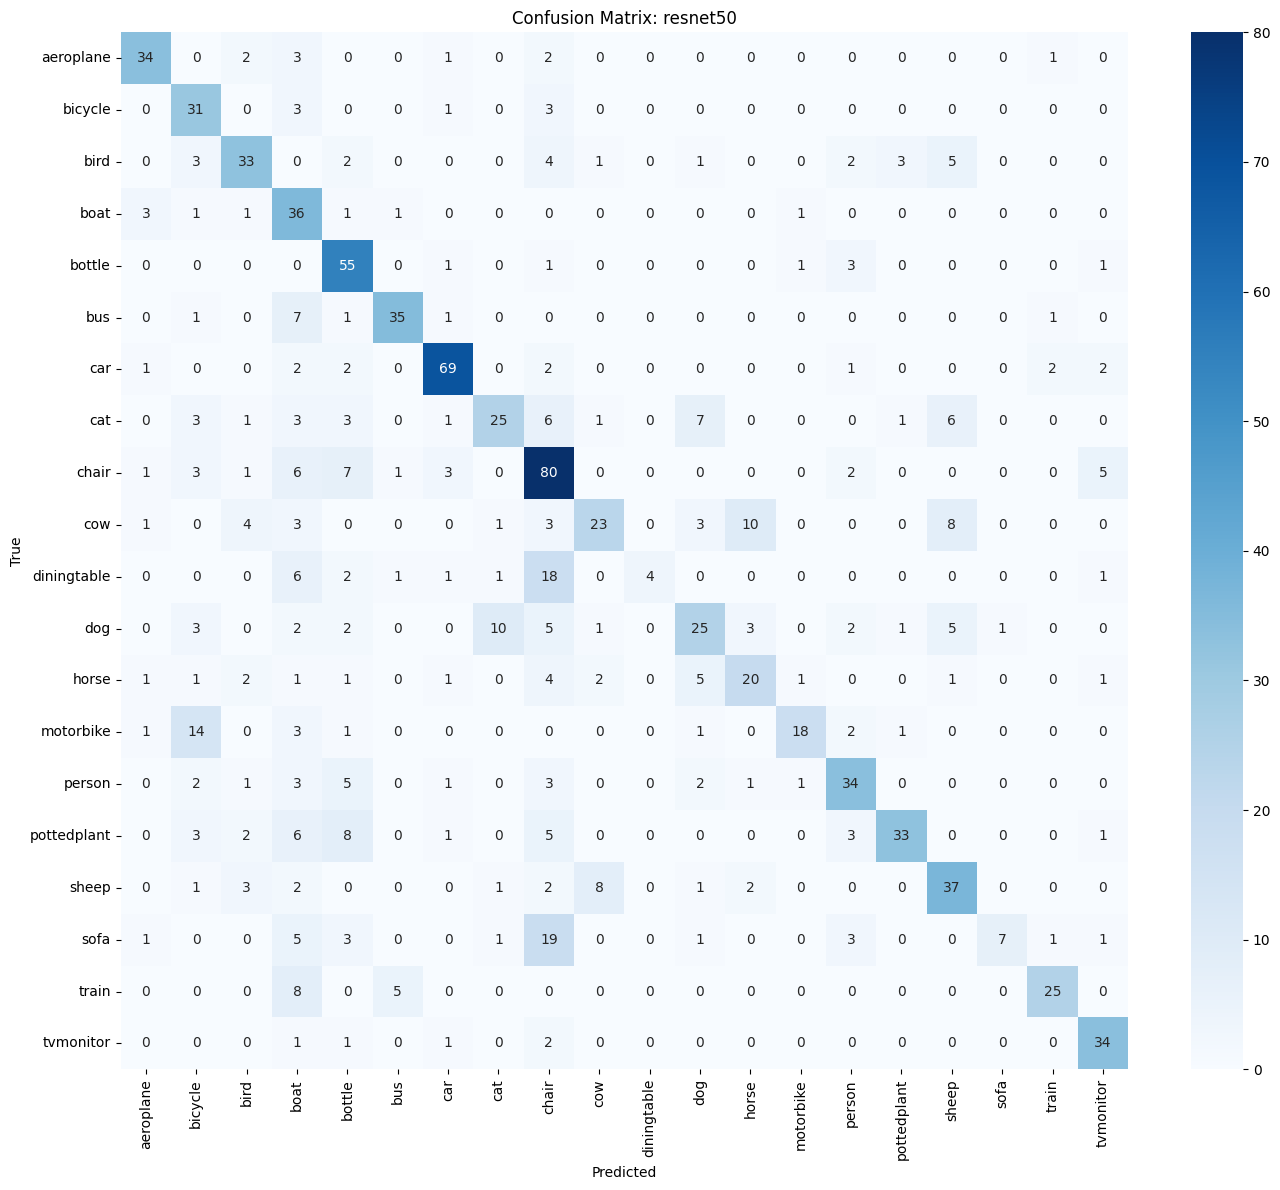

Model: mobilenet_v3_large
Test accuracy: 0.7446
              precision    recall  f1-score   support

   aeroplane       0.81      0.79      0.80        43
     bicycle       0.71      0.84      0.77        38
        bird       0.77      0.74      0.75        54
        boat       0.63      0.93      0.75        44
      bottle       0.89      0.87      0.88        62
         bus       0.80      0.98      0.88        46
         car       0.73      0.93      0.82        81
         cat       0.88      0.61      0.72        57
       chair       0.71      0.71      0.71       109
         cow       0.62      0.71      0.66        56
 diningtable       0.83      0.44      0.58        34
         dog       0.55      0.80      0.65        60
       horse       0.74      0.68      0.71        41
   motorbike       0.76      0.78      0.77        41
      person       0.90      0.49      0.63        53
 pottedplant       0.92      0.76      0.83        62
       sheep       0.77      0.60

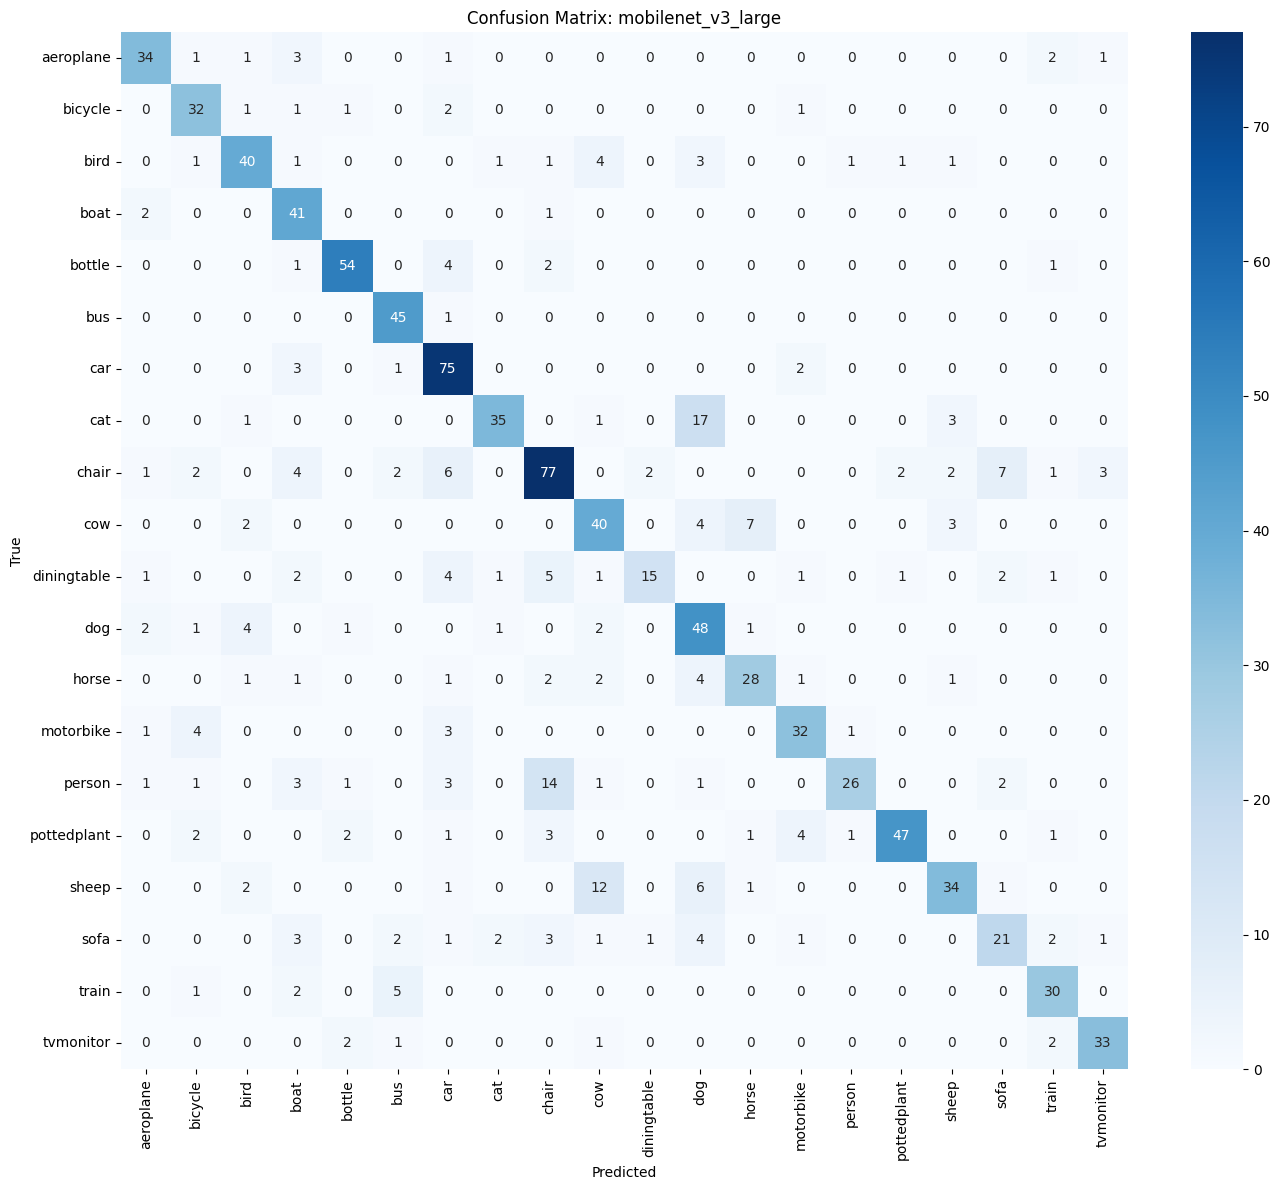

Model: shufflenet_v2_x1_0
Test accuracy: 0.7909
              precision    recall  f1-score   support

   aeroplane       0.97      0.77      0.86        43
     bicycle       0.82      0.87      0.85        38
        bird       0.78      0.74      0.76        54
        boat       0.84      0.73      0.78        44
      bottle       0.85      0.92      0.88        62
         bus       0.93      0.91      0.92        46
         car       0.83      0.96      0.89        81
         cat       0.77      0.88      0.82        57
       chair       0.70      0.72      0.71       109
         cow       0.75      0.82      0.79        56
 diningtable       0.80      0.47      0.59        34
         dog       0.68      0.67      0.67        60
       horse       0.74      0.49      0.59        41
   motorbike       0.88      0.68      0.77        41
      person       0.71      0.74      0.72        53
 pottedplant       0.77      0.90      0.83        62
       sheep       0.76      0.82

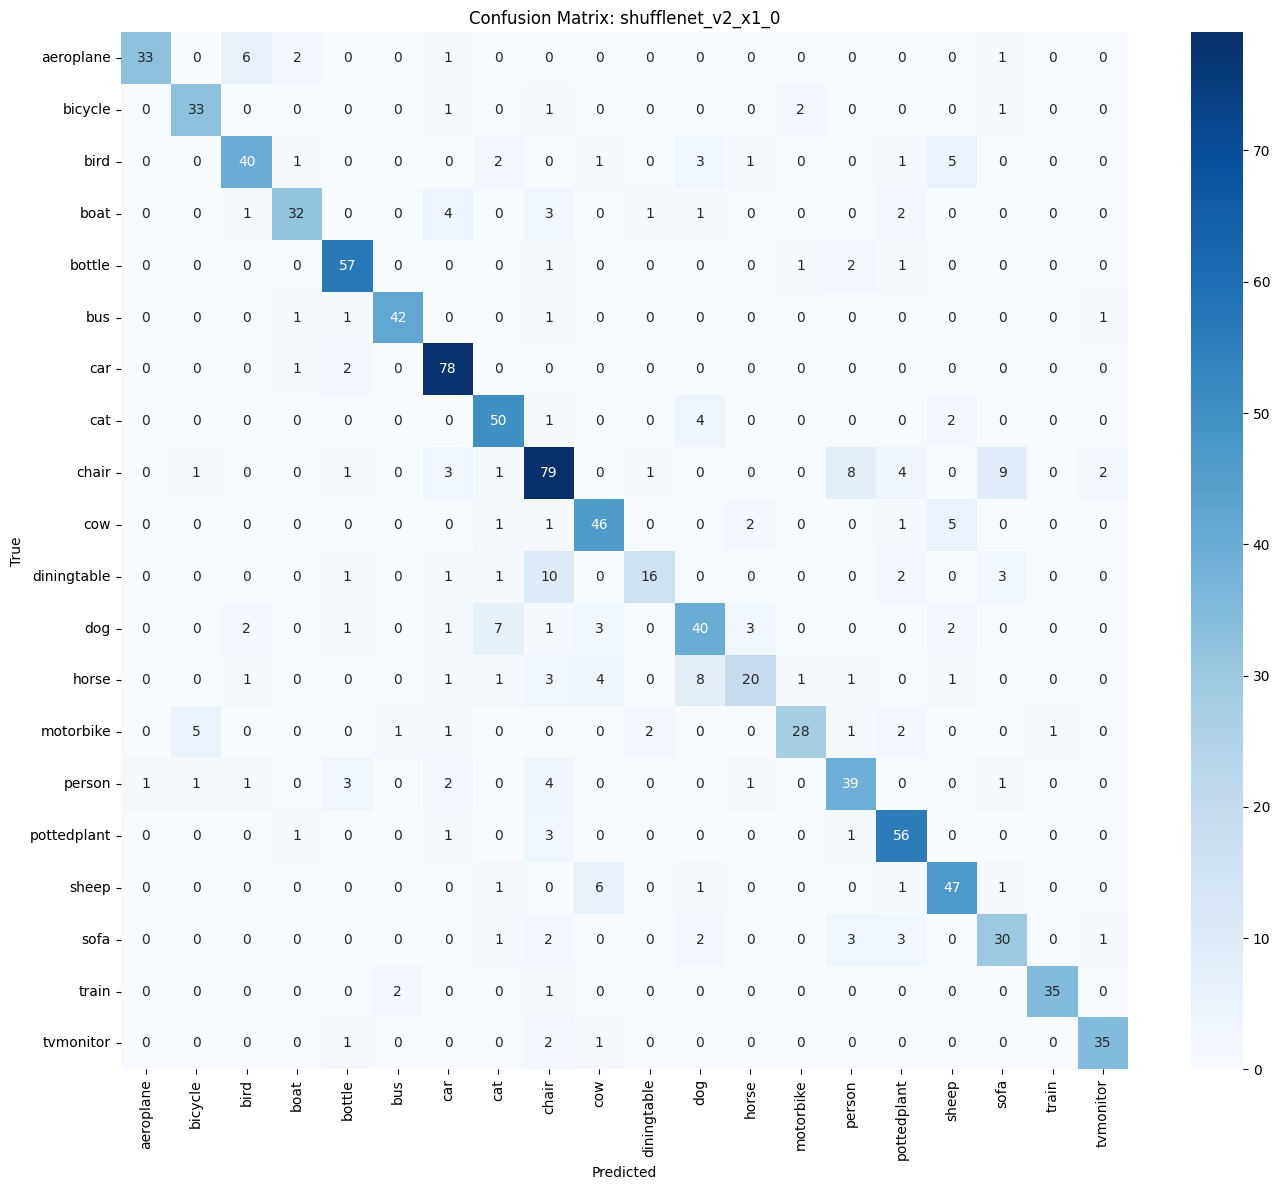

Model: efficientnet_b0
Test accuracy: 0.8146
              precision    recall  f1-score   support

   aeroplane       0.95      0.95      0.95        43
     bicycle       0.73      0.95      0.83        38
        bird       0.80      0.91      0.85        54
        boat       0.91      0.89      0.90        44
      bottle       0.80      0.90      0.85        62
         bus       0.96      0.93      0.95        46
         car       0.91      0.93      0.92        81
         cat       0.77      0.88      0.82        57
       chair       0.78      0.80      0.79       109
         cow       0.83      0.61      0.70        56
 diningtable       0.95      0.56      0.70        34
         dog       0.73      0.63      0.68        60
       horse       0.56      0.78      0.65        41
   motorbike       0.96      0.61      0.75        41
      person       0.75      0.75      0.75        53
 pottedplant       0.89      0.82      0.86        62
       sheep       0.78      0.86   

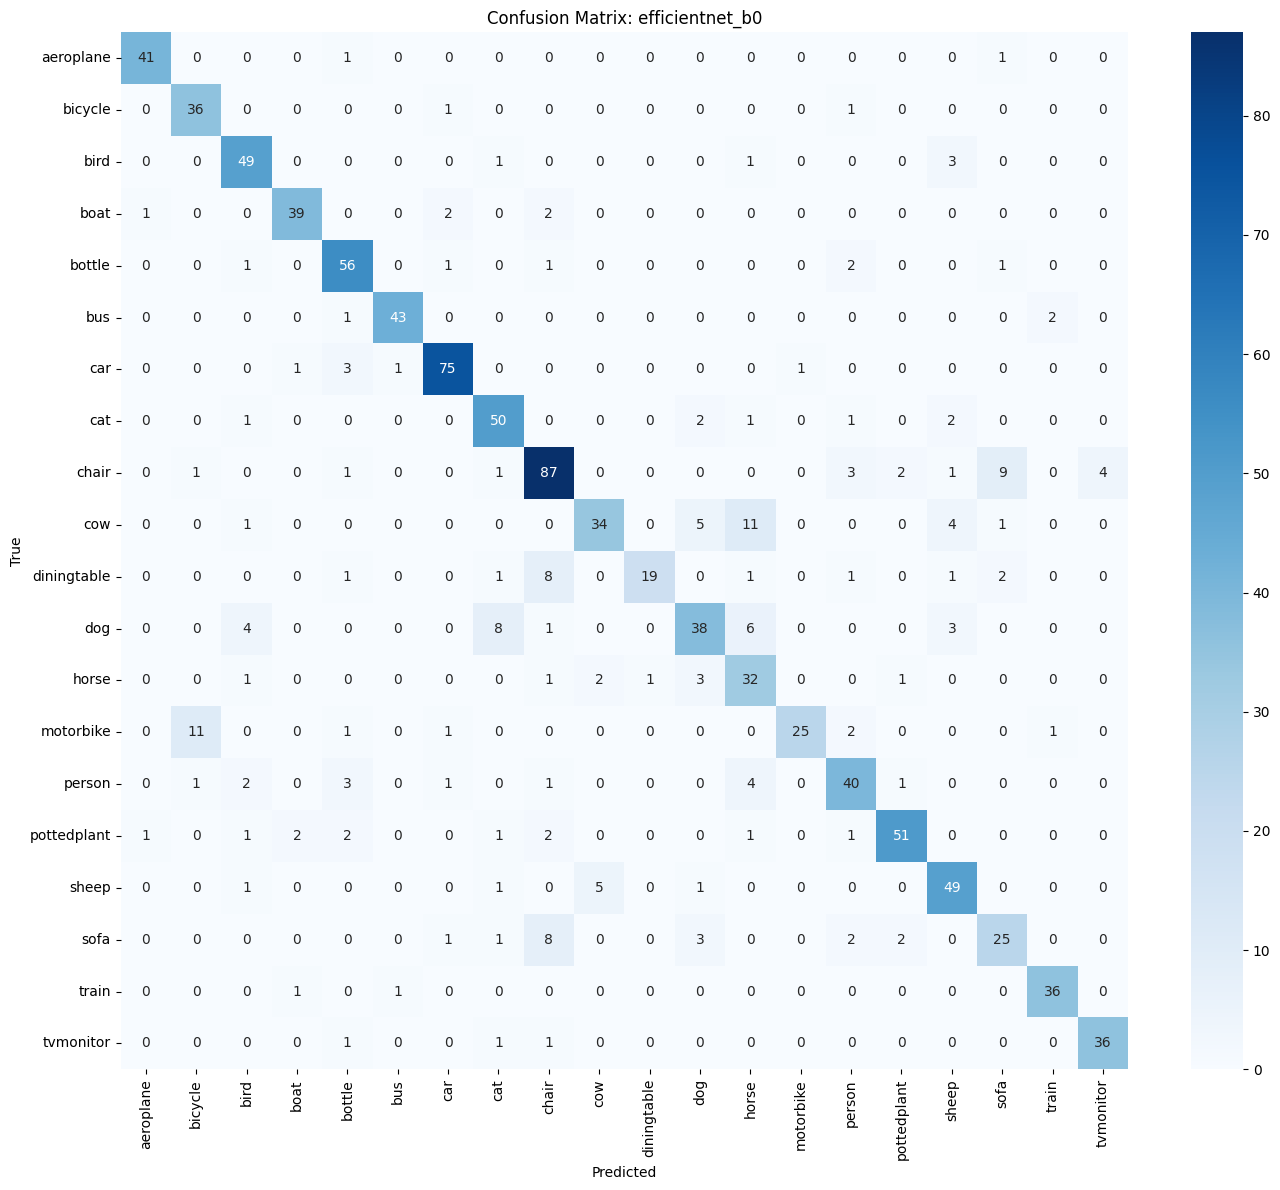

Model: squeezenet1_1
Test accuracy: 0.3396
              precision    recall  f1-score   support

   aeroplane       0.45      0.42      0.43        43
     bicycle       0.30      0.42      0.35        38
        bird       0.34      0.22      0.27        54
        boat       0.43      0.30      0.35        44
      bottle       0.31      0.63      0.41        62
         bus       0.46      0.67      0.54        46
         car       0.38      0.57      0.46        81
         cat       0.22      0.04      0.06        57
       chair       0.36      0.37      0.36       109
         cow       0.24      0.54      0.33        56
 diningtable       1.00      0.06      0.11        34
         dog       0.12      0.13      0.13        60
       horse       0.17      0.02      0.04        41
   motorbike       1.00      0.02      0.05        41
      person       0.00      0.00      0.00        53
 pottedplant       0.28      0.42      0.33        62
       sheep       0.38      0.67     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


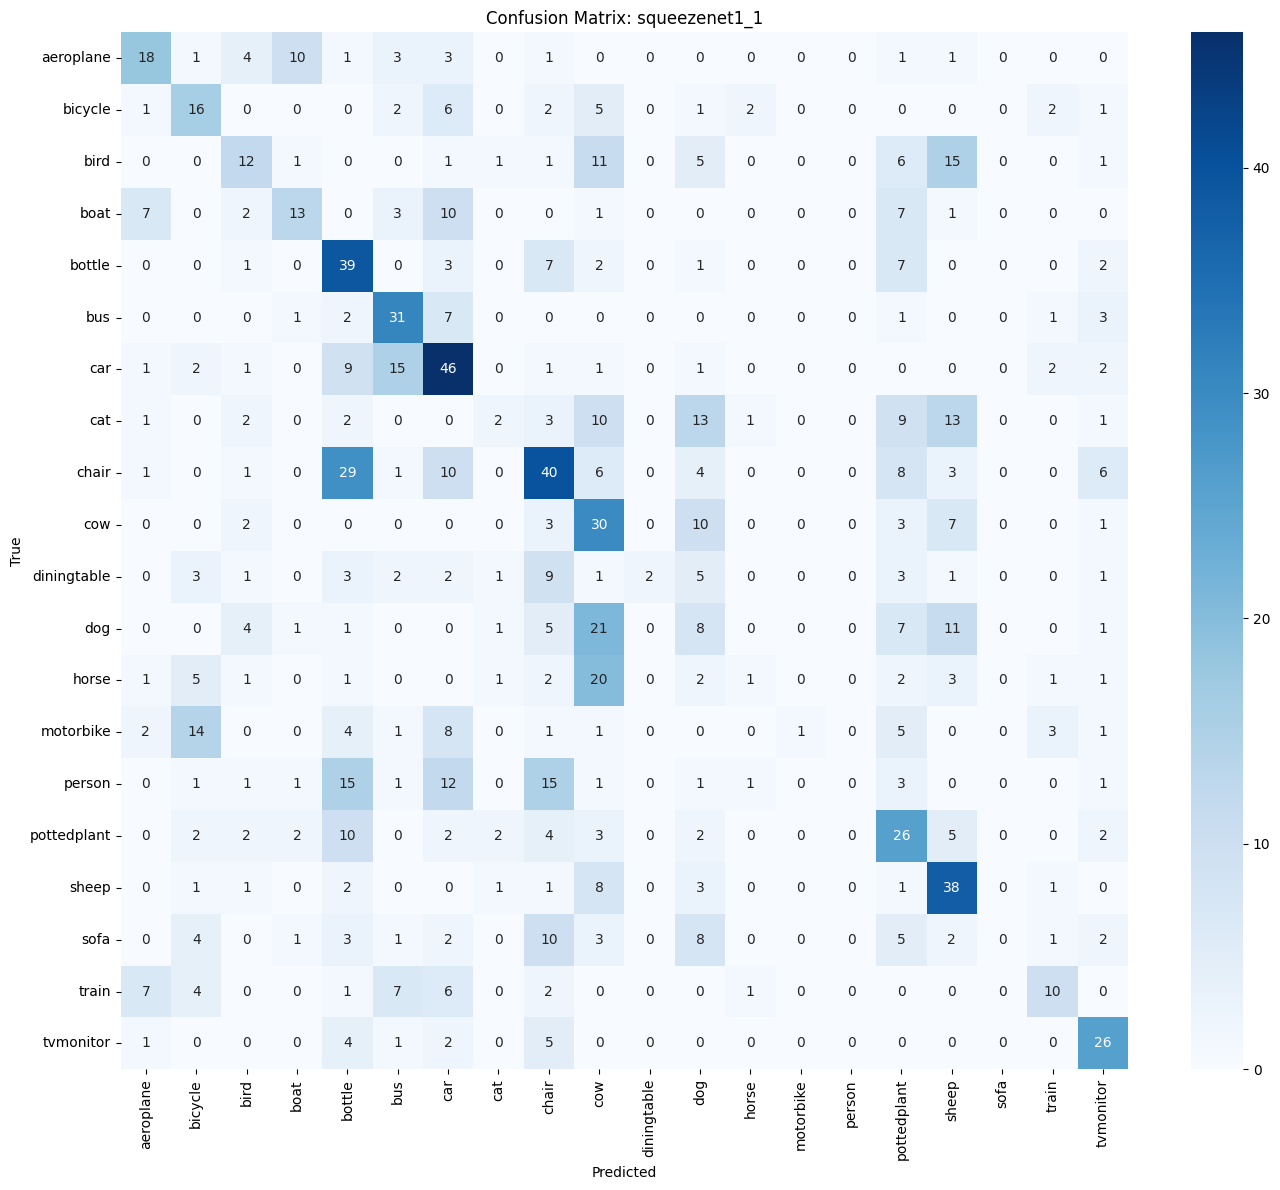

Model: wide_resnet50_2
Test accuracy: 0.3794
              precision    recall  f1-score   support

   aeroplane       0.54      0.60      0.57        43
     bicycle       0.33      0.45      0.38        38
        bird       0.25      0.44      0.32        54
        boat       0.69      0.45      0.55        44
      bottle       0.41      0.31      0.35        62
         bus       0.78      0.30      0.44        46
         car       0.43      0.44      0.44        81
         cat       0.37      0.53      0.43        57
       chair       0.47      0.34      0.39       109
         cow       0.40      0.18      0.25        56
 diningtable       0.29      0.12      0.17        34
         dog       0.19      0.38      0.25        60
       horse       0.25      0.02      0.04        41
   motorbike       0.31      0.10      0.15        41
      person       0.13      0.11      0.12        53
 pottedplant       0.53      0.71      0.61        62
       sheep       0.36      0.63   

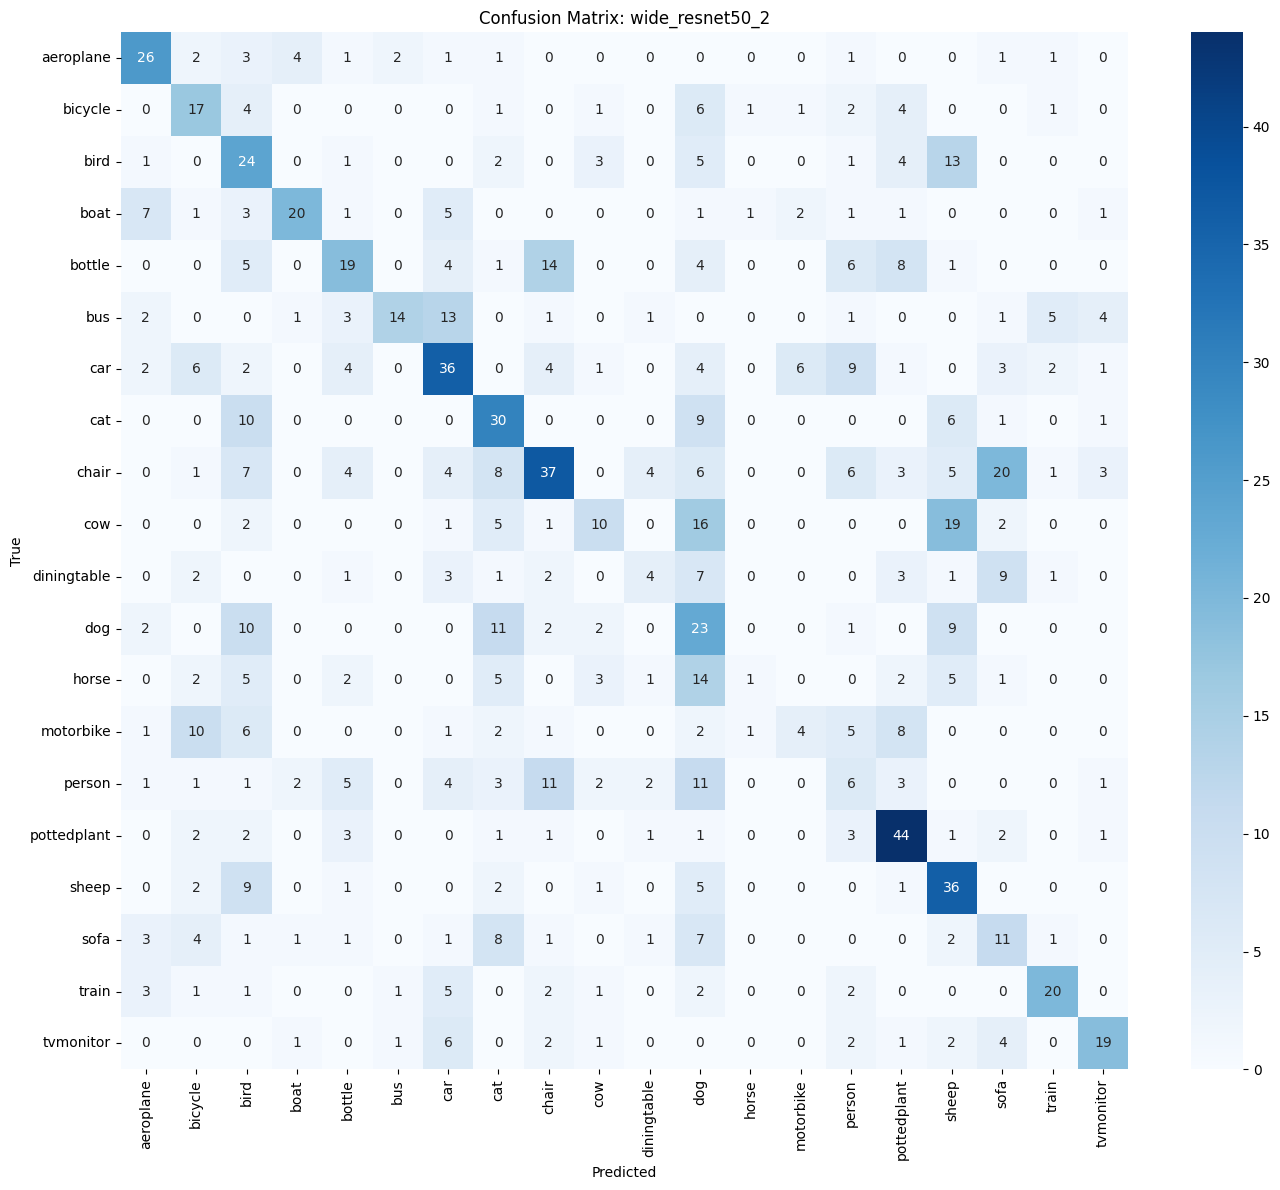

Model: convnext_tiny
Test accuracy: 0.7370
              precision    recall  f1-score   support

   aeroplane       0.92      0.81      0.86        43
     bicycle       1.00      0.66      0.79        38
        bird       0.84      0.48      0.61        54
        boat       0.86      0.84      0.85        44
      bottle       0.86      0.79      0.82        62
         bus       0.87      0.85      0.86        46
         car       0.95      0.89      0.92        81
         cat       0.65      0.88      0.75        57
       chair       0.53      0.90      0.66       109
         cow       1.00      0.41      0.58        56
 diningtable       1.00      0.21      0.34        34
         dog       0.76      0.47      0.58        60
       horse       0.75      0.66      0.70        41
   motorbike       0.91      0.73      0.81        41
      person       0.85      0.74      0.79        53
 pottedplant       0.56      0.95      0.70        62
       sheep       0.50      0.82     

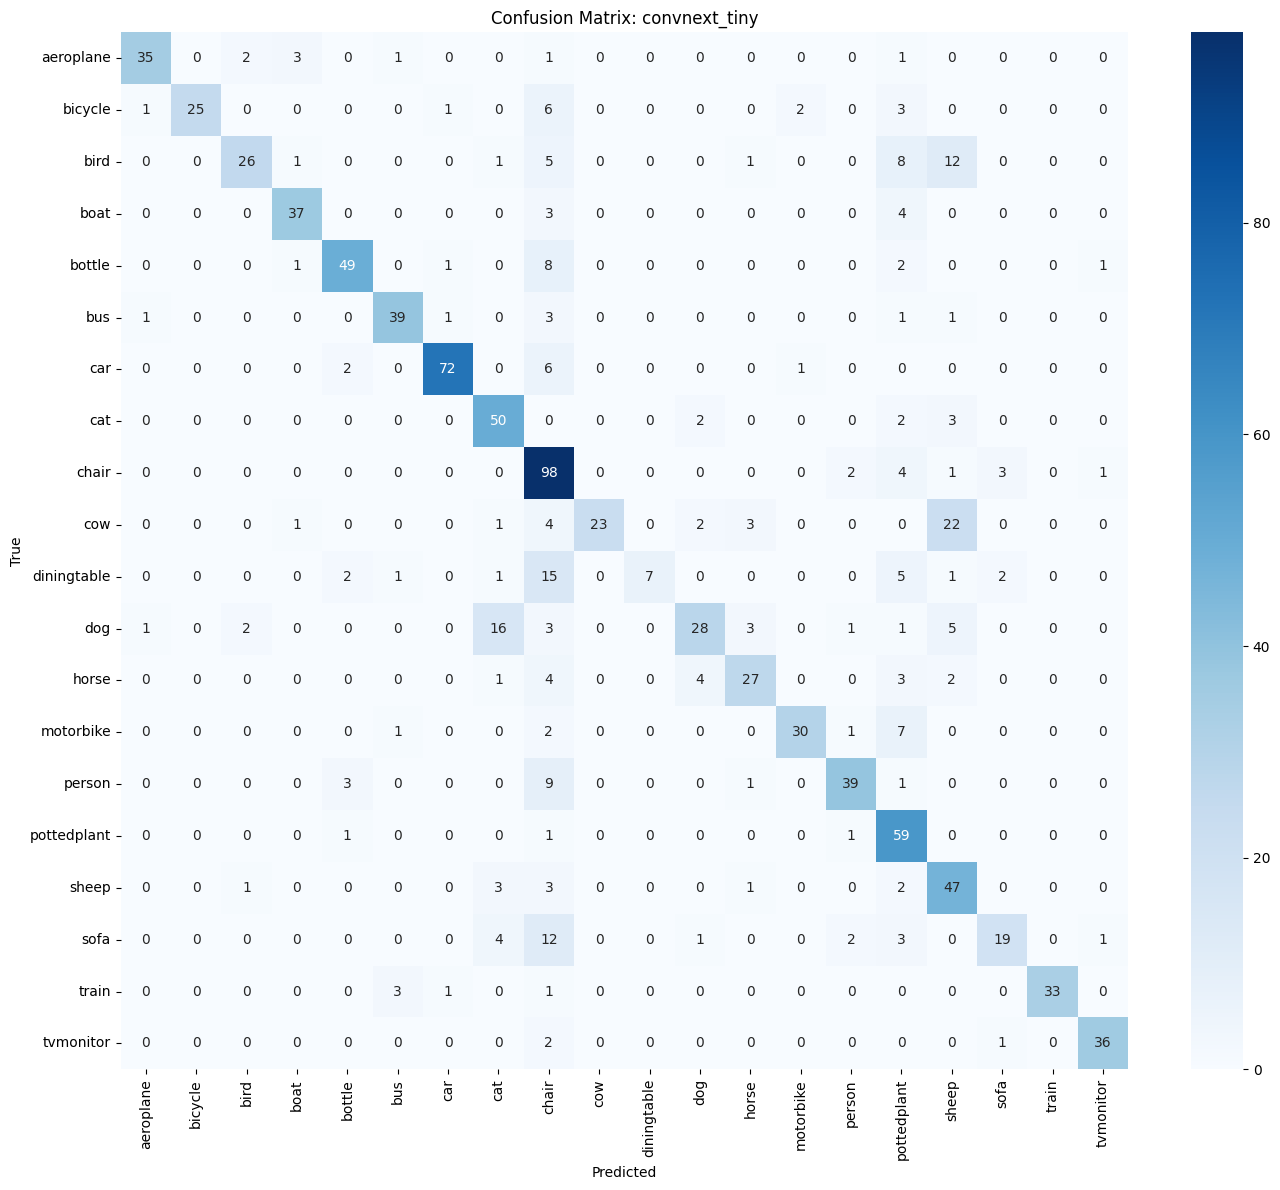

Model: vit_base_patch16_224
Test accuracy: 0.2148
              precision    recall  f1-score   support

   aeroplane       0.23      0.42      0.30        43
     bicycle       0.19      0.08      0.11        38
        bird       0.17      0.09      0.12        54
        boat       0.27      0.07      0.11        44
      bottle       0.28      0.26      0.27        62
         bus       0.00      0.00      0.00        46
         car       0.23      0.47      0.31        81
         cat       0.15      0.21      0.18        57
       chair       0.18      0.67      0.28       109
         cow       0.34      0.18      0.24        56
 diningtable       0.00      0.00      0.00        34
         dog       0.12      0.02      0.03        60
       horse       0.00      0.00      0.00        41
   motorbike       0.33      0.05      0.09        41
      person       0.05      0.06      0.05        53
 pottedplant       0.43      0.37      0.40        62
       sheep       0.49      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


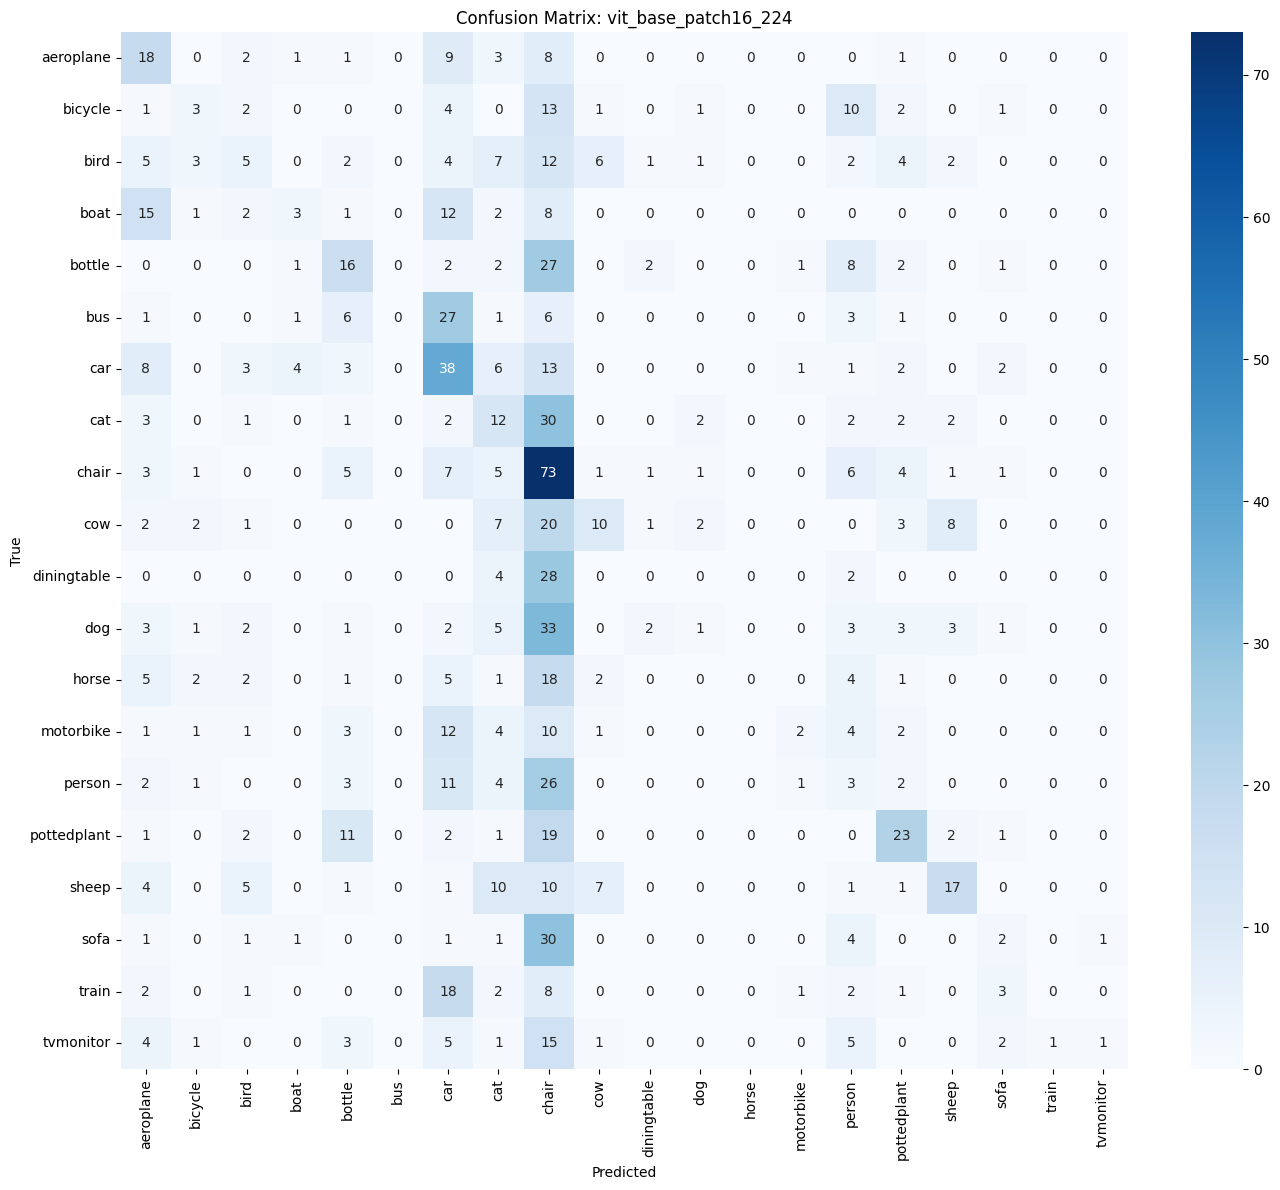

Model: swin_tiny_patch4_window7_224
Test accuracy: 0.1031
              precision    recall  f1-score   support

   aeroplane       0.00      0.00      0.00        43
     bicycle       0.00      0.00      0.00        38
        bird       0.00      0.00      0.00        54
        boat       0.00      0.00      0.00        44
      bottle       0.00      0.00      0.00        62
         bus       0.00      0.00      0.00        46
         car       0.00      0.00      0.00        81
         cat       0.00      0.00      0.00        57
       chair       0.10      1.00      0.19       109
         cow       0.00      0.00      0.00        56
 diningtable       0.00      0.00      0.00        34
         dog       0.00      0.00      0.00        60
       horse       0.00      0.00      0.00        41
   motorbike       0.00      0.00      0.00        41
      person       0.00      0.00      0.00        53
 pottedplant       0.00      0.00      0.00        62
       sheep       0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


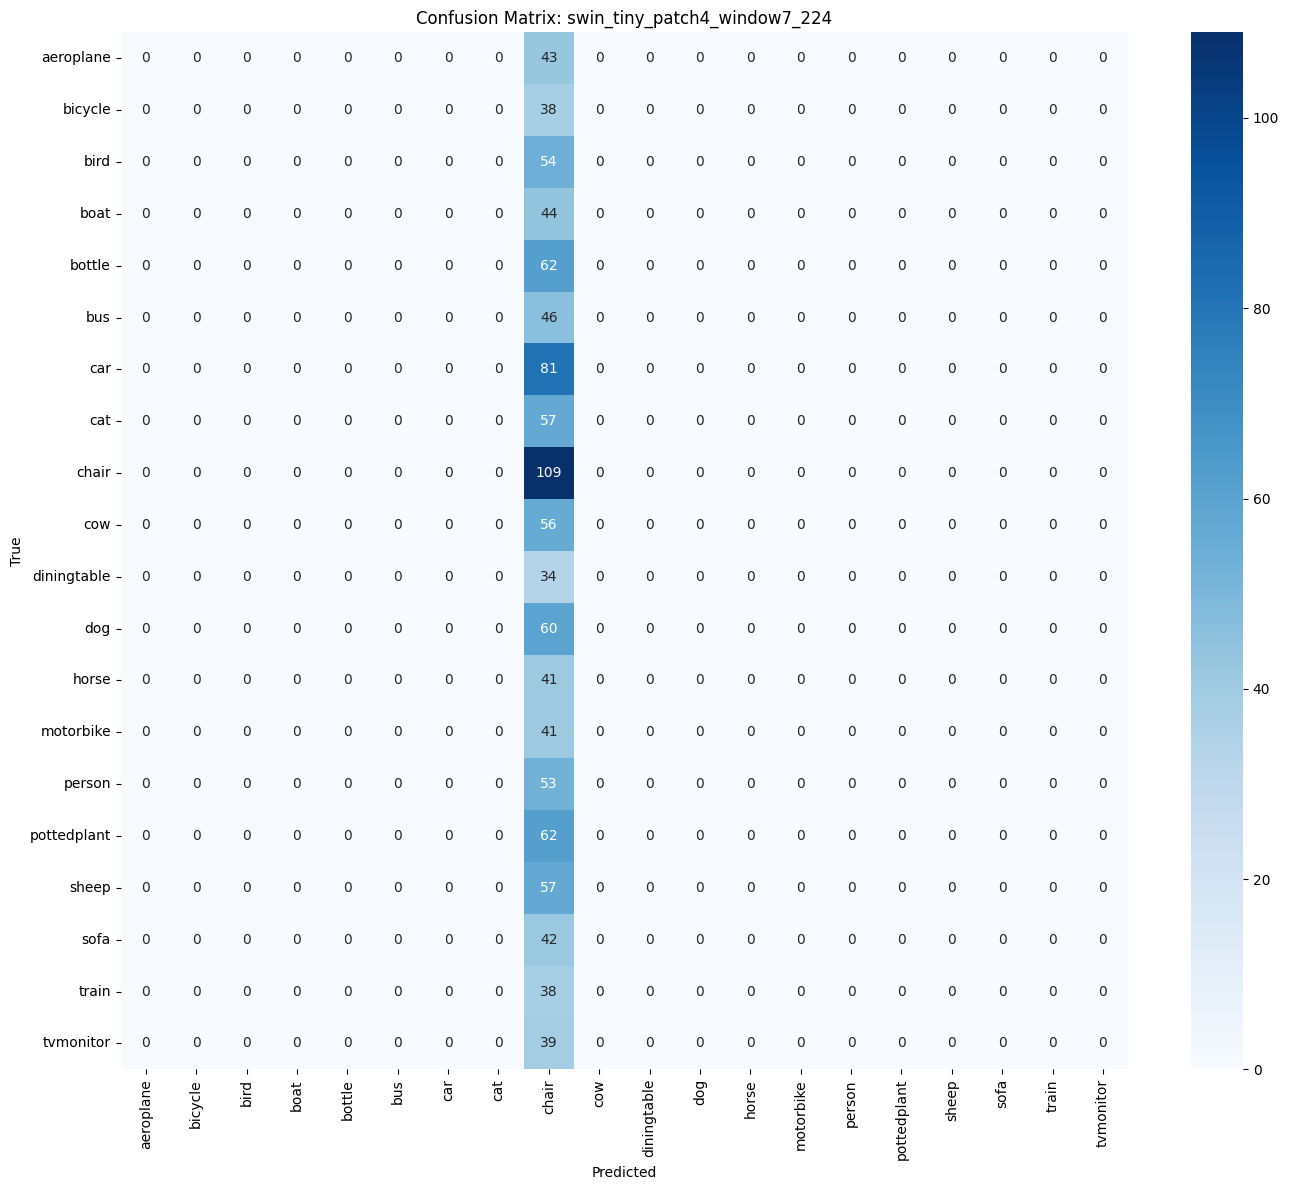

In [94]:
results = {}
for model_name in all_models:
    print("="*60)
    acc = evaluate_model(model_name, len(class_names), class_names, test_loader, device)
    results[model_name] = acc


Model: vit_base_patch16_224
Test accuracy: 0.1996
              precision    recall  f1-score   support

   aeroplane       0.41      0.16      0.23        43
     bicycle       0.09      0.08      0.08        38
        bird       0.14      0.06      0.08        54
        boat       0.25      0.25      0.25        44
      bottle       0.23      0.05      0.08        62
         bus       1.00      0.02      0.04        46
         car       0.18      0.47      0.26        81
         cat       0.33      0.04      0.06        57
       chair       0.20      0.49      0.29       109
         cow       0.18      0.18      0.18        56
 diningtable       0.00      0.00      0.00        34
         dog       0.67      0.03      0.06        60
       horse       0.00      0.00      0.00        41
   motorbike       0.00      0.00      0.00        41
      person       0.00      0.00      0.00        53
 pottedplant       0.19      0.63      0.29        62
       sheep       0.18      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


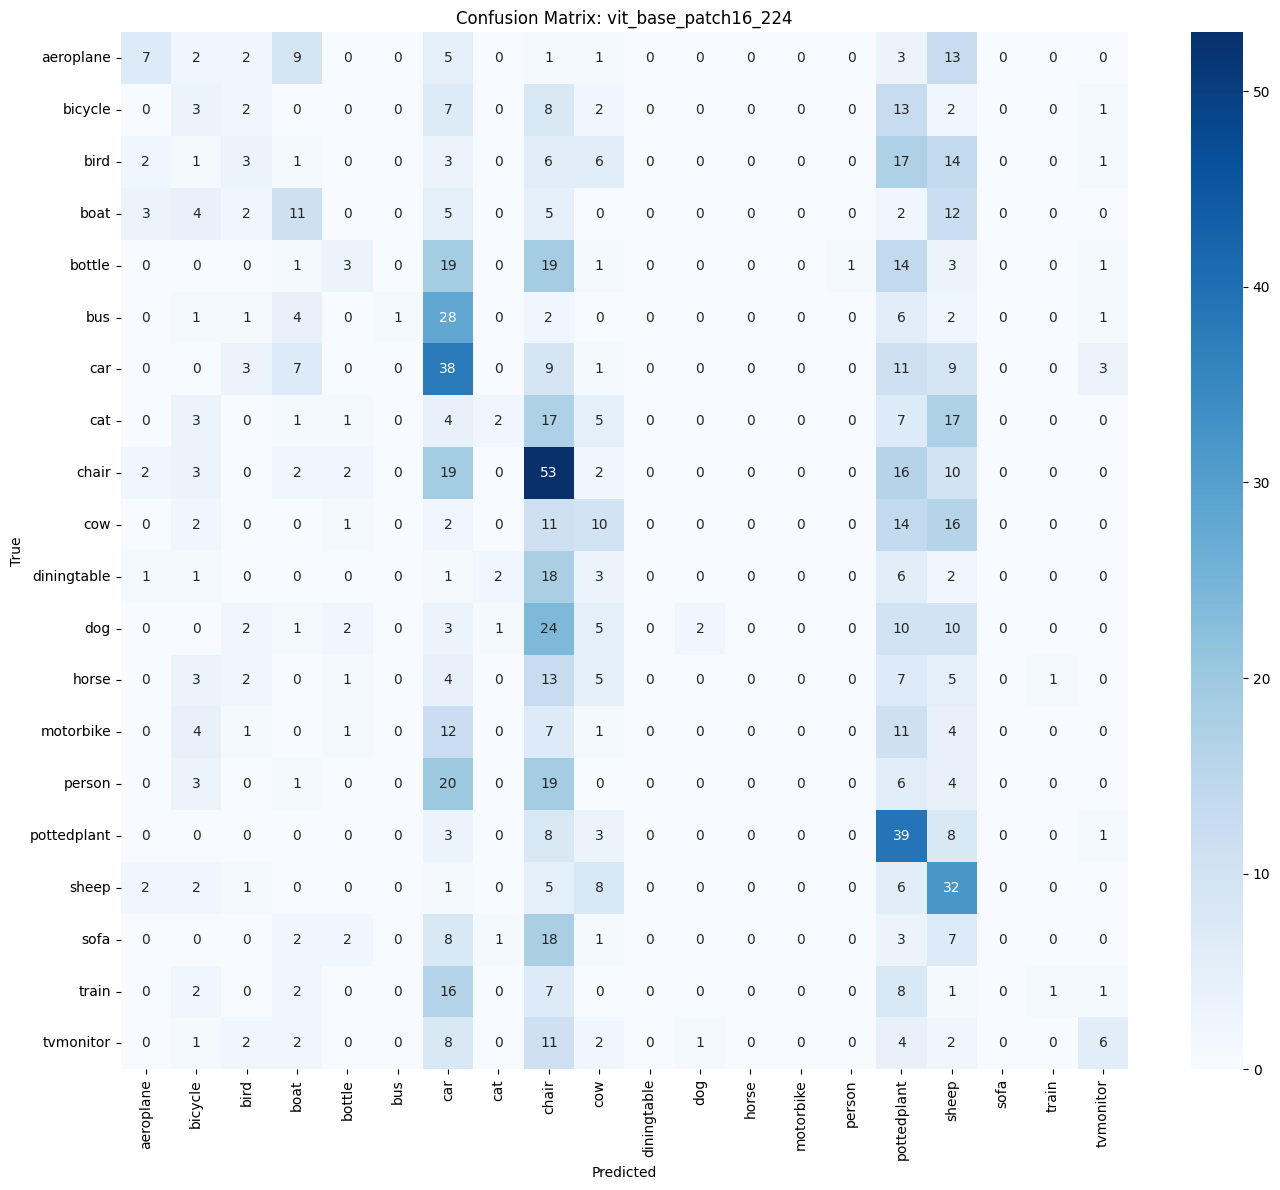

Model: swin_tiny_patch4_window7_224
Test accuracy: 0.1031
              precision    recall  f1-score   support

   aeroplane       0.00      0.00      0.00        43
     bicycle       0.00      0.00      0.00        38
        bird       0.00      0.00      0.00        54
        boat       0.00      0.00      0.00        44
      bottle       0.00      0.00      0.00        62
         bus       0.00      0.00      0.00        46
         car       0.00      0.00      0.00        81
         cat       0.00      0.00      0.00        57
       chair       0.10      1.00      0.19       109
         cow       0.00      0.00      0.00        56
 diningtable       0.00      0.00      0.00        34
         dog       0.00      0.00      0.00        60
       horse       0.00      0.00      0.00        41
   motorbike       0.00      0.00      0.00        41
      person       0.00      0.00      0.00        53
 pottedplant       0.00      0.00      0.00        62
       sheep       0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


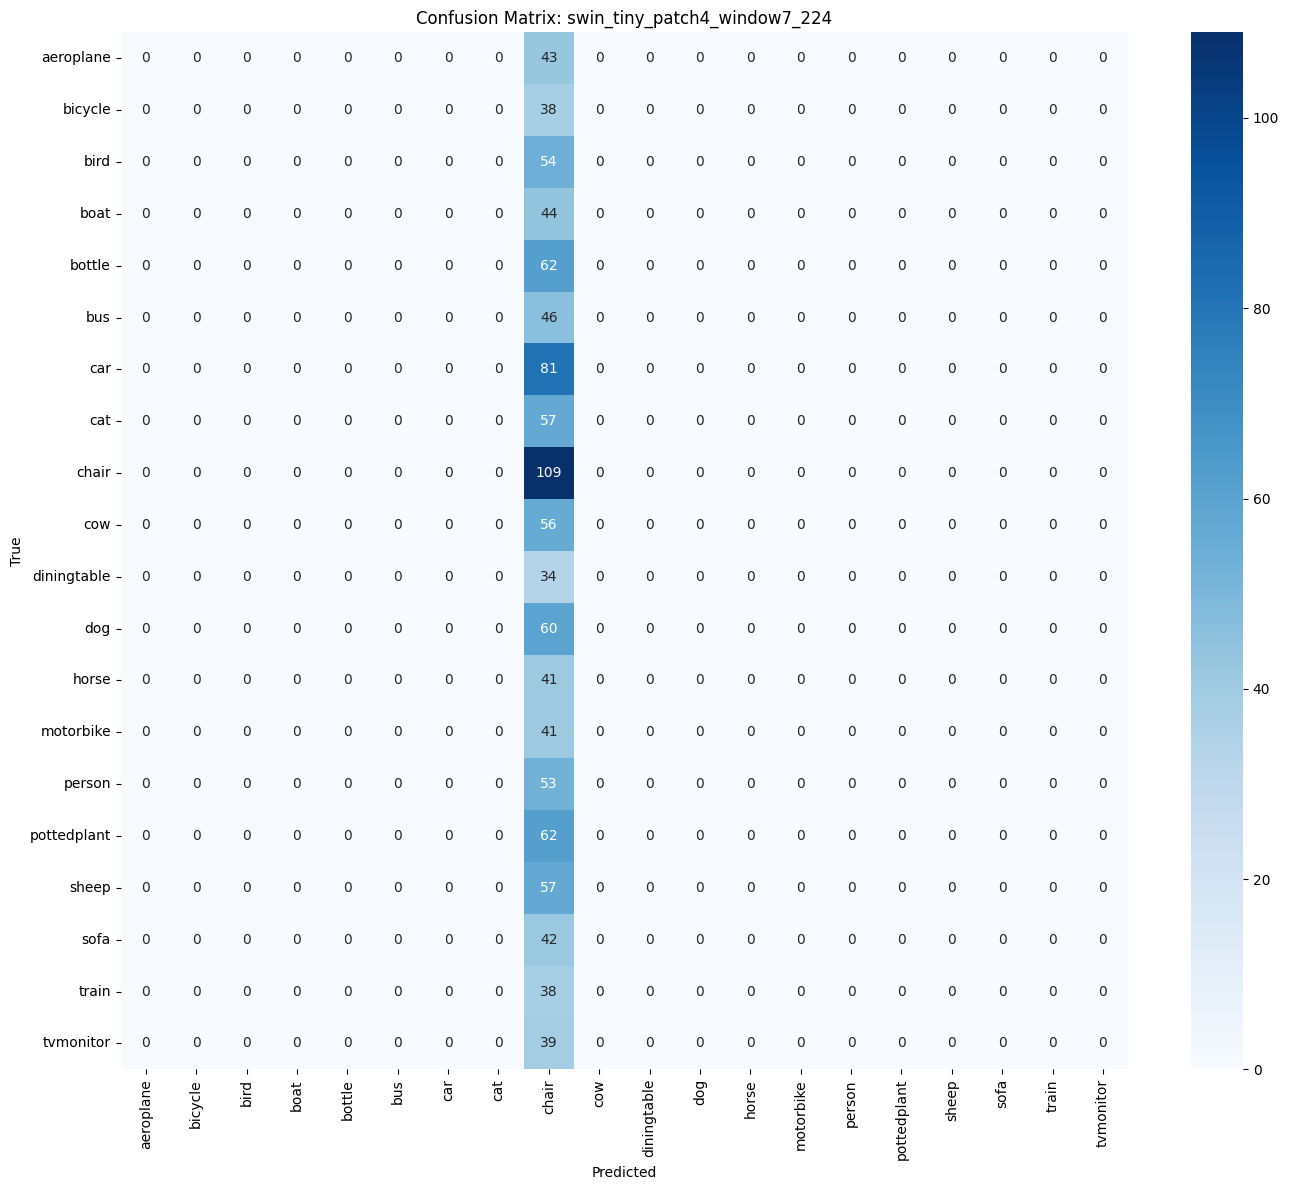

In [32]:
results = {}
for model_name in all_models:
    print("="*60)
    acc = evaluate_model(model_name, len(class_names), class_names, test_loader, device)
    results[model_name] = acc


In [47]:
model = get_model("shufflenet_v2_x1_0", num_classes=len(class_names), pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True


In [48]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [49]:
trained_model, history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=10, 
    scheduler=None,
    return_best=True,
    save_best_path="best_shufflenet_v2_x1_0_headonly.pth"
)


Epoch 1/10 | Train Loss: 2.8735 Acc: 0.1178 | Val Loss: 2.7601 Acc: 0.1704
Epoch 2/10 | Train Loss: 2.6701 Acc: 0.2142 | Val Loss: 2.5757 Acc: 0.3408
Epoch 3/10 | Train Loss: 2.4865 Acc: 0.4228 | Val Loss: 2.4024 Acc: 0.4923
Epoch 4/10 | Train Loss: 2.3215 Acc: 0.5405 | Val Loss: 2.2563 Acc: 0.5728
Epoch 5/10 | Train Loss: 2.1790 Acc: 0.6059 | Val Loss: 2.1207 Acc: 0.6047
Epoch 6/10 | Train Loss: 2.0434 Acc: 0.6488 | Val Loss: 1.9902 Acc: 0.6308
Epoch 7/10 | Train Loss: 1.9250 Acc: 0.6796 | Val Loss: 1.8881 Acc: 0.6604
Epoch 8/10 | Train Loss: 1.8175 Acc: 0.6947 | Val Loss: 1.7840 Acc: 0.6757
Epoch 9/10 | Train Loss: 1.7164 Acc: 0.7186 | Val Loss: 1.6995 Acc: 0.6781
Epoch 10/10 | Train Loss: 1.6357 Acc: 0.7251 | Val Loss: 1.6255 Acc: 0.6817


In [51]:
def evaluate_model(model_name, num_classes, class_names, test_loader, device, checkpoint_path=None):
    if checkpoint_path is None:
        checkpoint_path = f"best_{model_name}.pth"
    model = get_model(model_name, num_classes=num_classes, pretrained=False).to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    # 2. Predict on test set
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # 3. Print metrics
    acc = accuracy_score(all_labels, all_preds)
    print(f"Model: {model_name}")
    print(f"Test accuracy: {acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(14,12))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()
    
    return acc


Model: shufflenet_v2_x1_0
Test accuracy: 0.7039
              precision    recall  f1-score   support

   aeroplane       1.00      0.88      0.94        43
     bicycle       0.83      0.76      0.79        38
        bird       0.82      0.74      0.78        54
        boat       1.00      0.64      0.78        44
      bottle       0.69      0.90      0.78        62
         bus       0.80      0.78      0.79        46
         car       0.70      0.88      0.78        81
         cat       0.72      0.82      0.77        57
       chair       0.47      0.84      0.61       109
         cow       0.72      0.68      0.70        56
 diningtable       1.00      0.18      0.30        34
         dog       0.72      0.63      0.67        60
       horse       0.76      0.39      0.52        41
   motorbike       0.69      0.71      0.70        41
      person       0.59      0.49      0.54        53
 pottedplant       0.66      0.74      0.70        62
       sheep       0.70      0.84

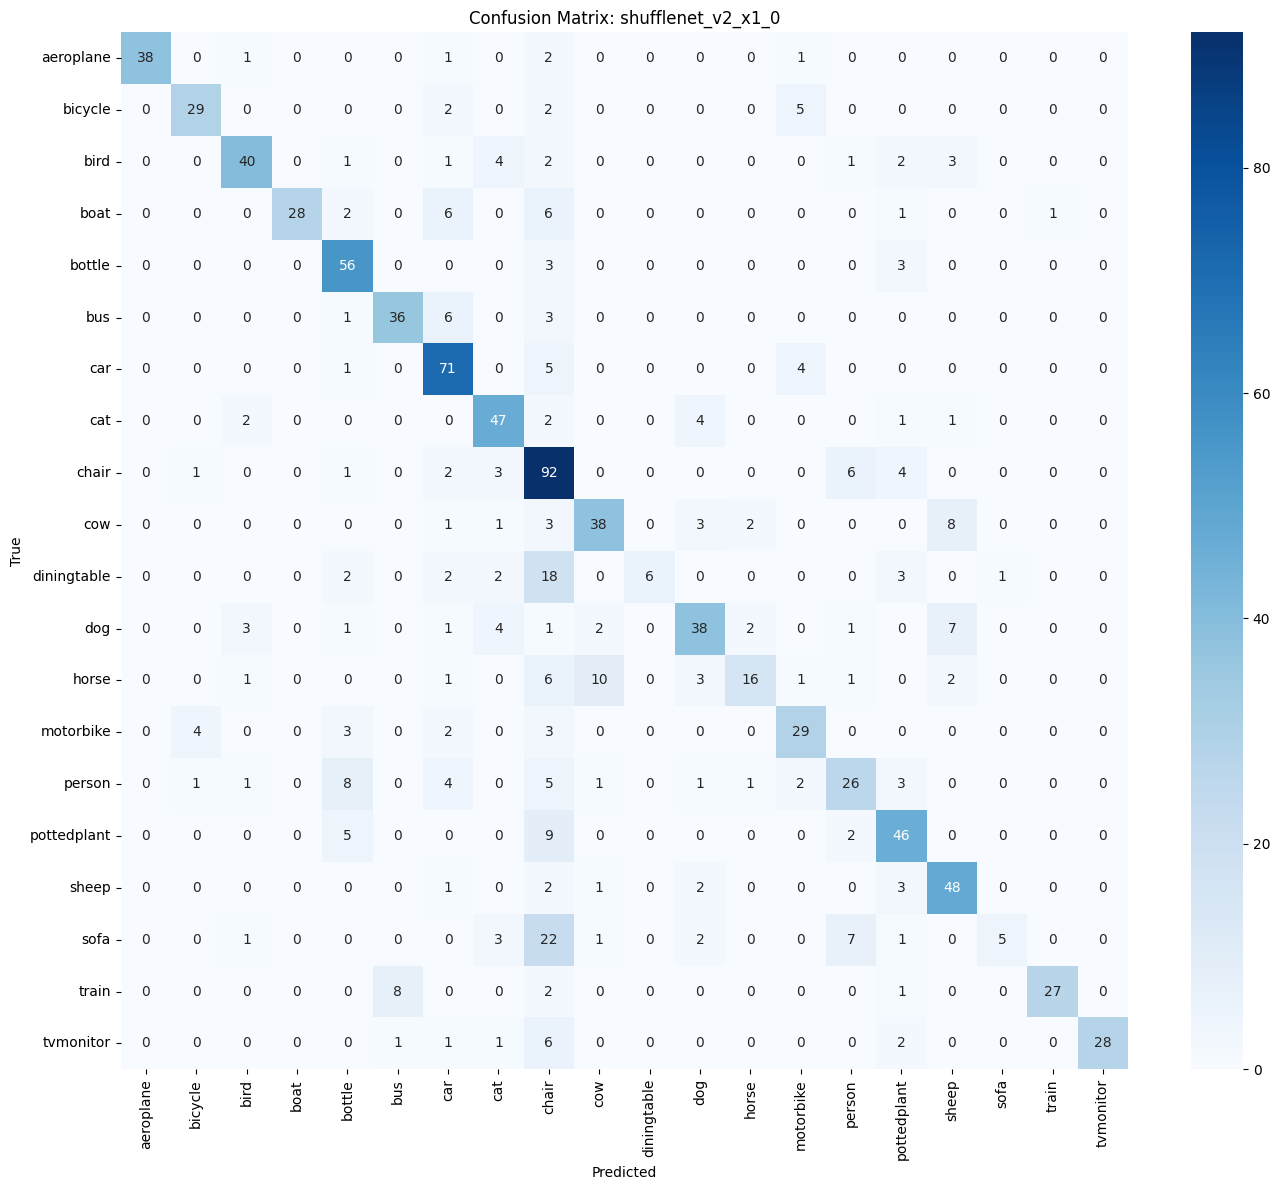

0.7038789025543992

In [52]:
evaluate_model(
    "shufflenet_v2_x1_0",
    len(class_names),
    class_names,
    test_loader,
    device,
    checkpoint_path="best_shufflenet_v2_x1_0_headonly.pth"
)


In [43]:
model = get_model("efficientnet_b0", num_classes=len(class_names), pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[-1].parameters():
    param.requires_grad = True


In [45]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

trained_model, history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=10, 
    scheduler=None,
    return_best=True,
    save_best_path="best_efficientnet_b0_headonly.pth"
)


Epoch 1/10 | Train Loss: 1.8330 Acc: 0.5929 | Val Loss: 1.1190 Acc: 0.7882
Epoch 2/10 | Train Loss: 0.9201 Acc: 0.7820 | Val Loss: 0.8438 Acc: 0.7929
Epoch 3/10 | Train Loss: 0.7207 Acc: 0.8071 | Val Loss: 0.7284 Acc: 0.8154
Epoch 4/10 | Train Loss: 0.6239 Acc: 0.8314 | Val Loss: 0.6947 Acc: 0.8166
Epoch 5/10 | Train Loss: 0.5640 Acc: 0.8334 | Val Loss: 0.6714 Acc: 0.8142
Epoch 6/10 | Train Loss: 0.5192 Acc: 0.8553 | Val Loss: 0.6632 Acc: 0.8118
Epoch 7/10 | Train Loss: 0.4837 Acc: 0.8675 | Val Loss: 0.6548 Acc: 0.8095
Epoch 8/10 | Train Loss: 0.4715 Acc: 0.8592 | Val Loss: 0.6411 Acc: 0.8237
Epoch 9/10 | Train Loss: 0.4279 Acc: 0.8784 | Val Loss: 0.6470 Acc: 0.8047
Epoch 10/10 | Train Loss: 0.3992 Acc: 0.8905 | Val Loss: 0.6158 Acc: 0.8213


Model: efficientnet_b0
Test accuracy: 0.8098
              precision    recall  f1-score   support

   aeroplane       0.95      0.95      0.95        43
     bicycle       0.77      0.89      0.83        38
        bird       0.90      0.85      0.88        54
        boat       0.93      0.84      0.88        44
      bottle       0.81      0.84      0.83        62
         bus       0.98      0.89      0.93        46
         car       0.72      0.88      0.79        81
         cat       0.88      0.89      0.89        57
       chair       0.77      0.72      0.75       109
         cow       0.75      0.86      0.80        56
 diningtable       0.68      0.56      0.61        34
         dog       0.78      0.88      0.83        60
       horse       0.84      0.78      0.81        41
   motorbike       0.86      0.73      0.79        41
      person       0.51      0.49      0.50        53
 pottedplant       0.79      0.89      0.83        62
       sheep       0.80      0.77   

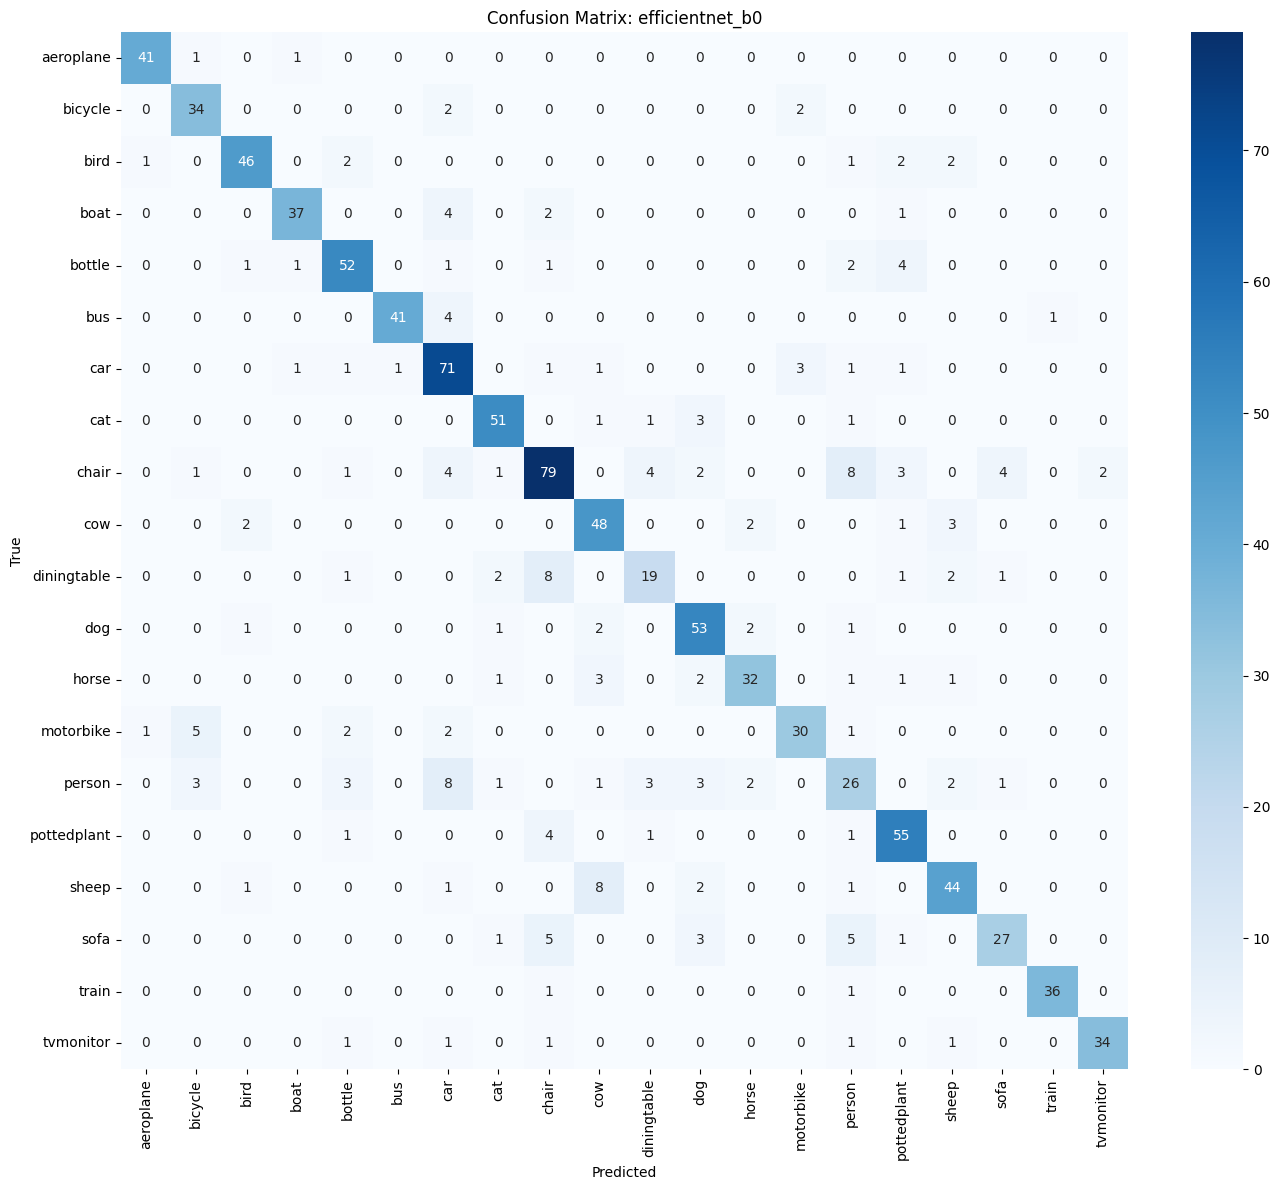

0.8098391674550615

In [50]:
evaluate_model(
    "efficientnet_b0",
    len(class_names),
    class_names,
    test_loader,
    device,
    checkpoint_path="best_efficientnet_b0_headonly.pth"
)


In [38]:
model = get_model("mobilenet_v3_large", num_classes=len(class_names), pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[-1].parameters():
    param.requires_grad = True


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 80.9MB/s]


In [39]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

trained_model, history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=10, 
    scheduler=None,
    return_best=True,
    save_best_path="best_mobilenet_v3_large_headonly.pth"
)


Epoch 1/10 | Train Loss: 1.3961 Acc: 0.6831 | Val Loss: 0.7957 Acc: 0.8083
Epoch 2/10 | Train Loss: 0.6371 Acc: 0.8346 | Val Loss: 0.6740 Acc: 0.8178
Epoch 3/10 | Train Loss: 0.4988 Acc: 0.8621 | Val Loss: 0.5995 Acc: 0.8308
Epoch 4/10 | Train Loss: 0.4219 Acc: 0.8867 | Val Loss: 0.5742 Acc: 0.8178
Epoch 5/10 | Train Loss: 0.3633 Acc: 0.8976 | Val Loss: 0.5669 Acc: 0.8130
Epoch 6/10 | Train Loss: 0.3190 Acc: 0.9145 | Val Loss: 0.5658 Acc: 0.8189
Epoch 7/10 | Train Loss: 0.3017 Acc: 0.9189 | Val Loss: 0.5687 Acc: 0.8154
Epoch 8/10 | Train Loss: 0.2698 Acc: 0.9311 | Val Loss: 0.5680 Acc: 0.8189
Epoch 9/10 | Train Loss: 0.2444 Acc: 0.9379 | Val Loss: 0.5712 Acc: 0.8189
Epoch 10/10 | Train Loss: 0.2343 Acc: 0.9346 | Val Loss: 0.5746 Acc: 0.8142


Model: mobilenet_v3_large
Test accuracy: 0.8231
              precision    recall  f1-score   support

   aeroplane       0.95      0.93      0.94        43
     bicycle       0.87      0.87      0.87        38
        bird       0.94      0.87      0.90        54
        boat       0.93      0.84      0.88        44
      bottle       0.86      0.90      0.88        62
         bus       0.96      0.93      0.95        46
         car       0.81      0.91      0.86        81
         cat       0.88      0.91      0.90        57
       chair       0.74      0.75      0.75       109
         cow       0.67      0.86      0.75        56
 diningtable       0.69      0.59      0.63        34
         dog       0.87      0.78      0.82        60
       horse       0.83      0.73      0.78        41
   motorbike       0.89      0.83      0.86        41
      person       0.58      0.68      0.63        53
 pottedplant       0.85      0.84      0.85        62
       sheep       0.81      0.75

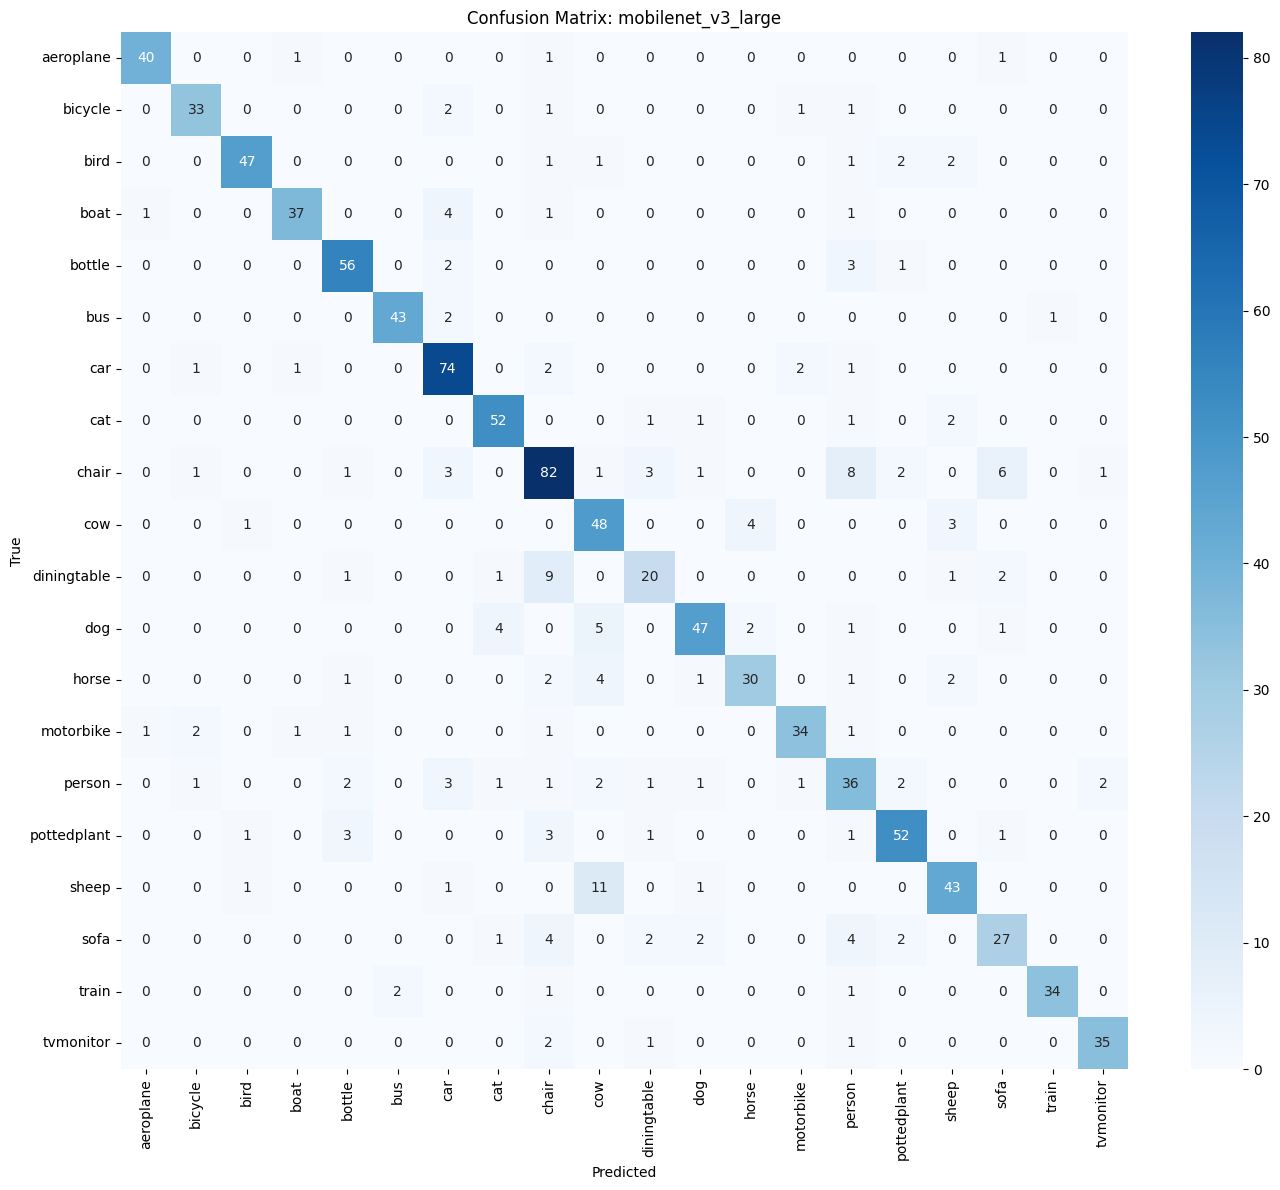

0.8230842005676443

In [41]:
evaluate_model(
    "mobilenet_v3_large",
    len(class_names),
    class_names,
    test_loader,
    device,
    checkpoint_path="best_mobilenet_v3_large_headonly.pth"
)


In [53]:
model = get_model("mobilenet_v3_large", num_classes=len(class_names), pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[-1].parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

trained_model, history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    scheduler=None,
    return_best=True,
    save_best_path="best_mobilenet_v3_large_headonly_adam.pth"
)


Epoch 1/10 | Train Loss: 1.3774 Acc: 0.6707 | Val Loss: 0.7827 Acc: 0.8047
Epoch 2/10 | Train Loss: 0.6386 Acc: 0.8290 | Val Loss: 0.6716 Acc: 0.8178
Epoch 3/10 | Train Loss: 0.4978 Acc: 0.8645 | Val Loss: 0.6076 Acc: 0.8249
Epoch 4/10 | Train Loss: 0.4189 Acc: 0.8849 | Val Loss: 0.5781 Acc: 0.8284
Epoch 5/10 | Train Loss: 0.3590 Acc: 0.9038 | Val Loss: 0.5708 Acc: 0.8237
Epoch 6/10 | Train Loss: 0.3246 Acc: 0.9098 | Val Loss: 0.5725 Acc: 0.8213
Epoch 7/10 | Train Loss: 0.2971 Acc: 0.9219 | Val Loss: 0.5630 Acc: 0.8225
Epoch 8/10 | Train Loss: 0.2728 Acc: 0.9254 | Val Loss: 0.5714 Acc: 0.8154
Epoch 9/10 | Train Loss: 0.2414 Acc: 0.9352 | Val Loss: 0.5630 Acc: 0.8225
Epoch 10/10 | Train Loss: 0.2294 Acc: 0.9408 | Val Loss: 0.5656 Acc: 0.8189


Model: mobilenet_v3_large
Test accuracy: 0.8278
              precision    recall  f1-score   support

   aeroplane       0.95      0.93      0.94        43
     bicycle       0.94      0.82      0.87        38
        bird       0.90      0.85      0.88        54
        boat       0.95      0.84      0.89        44
      bottle       0.81      0.94      0.87        62
         bus       0.93      0.91      0.92        46
         car       0.77      0.93      0.84        81
         cat       0.87      0.93      0.90        57
       chair       0.79      0.77      0.78       109
         cow       0.78      0.82      0.80        56
 diningtable       0.70      0.62      0.66        34
         dog       0.80      0.82      0.81        60
       horse       0.86      0.73      0.79        41
   motorbike       0.88      0.88      0.88        41
      person       0.60      0.62      0.61        53
 pottedplant       0.87      0.84      0.85        62
       sheep       0.78      0.88

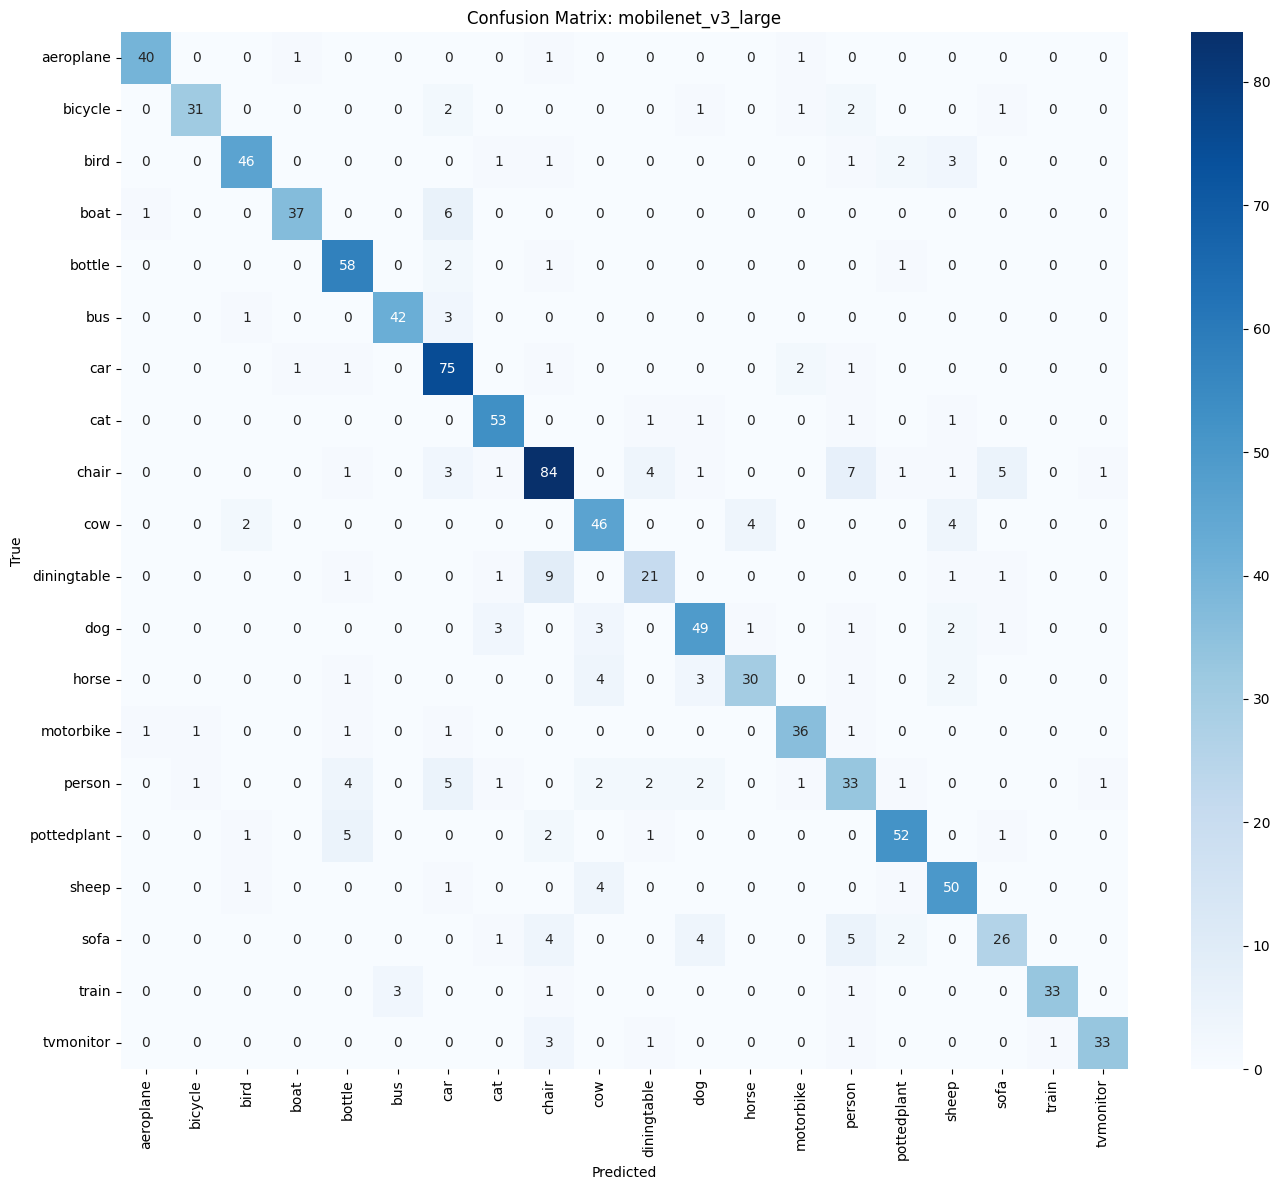

0.8278145695364238

In [54]:
evaluate_model(
    "mobilenet_v3_large",
    len(class_names),
    class_names,
    test_loader,
    device,
    checkpoint_path="best_mobilenet_v3_large_headonly_adam.pth"
)


In [55]:
model = get_model("mobilenet_v3_large", num_classes=len(class_names), pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[-1].parameters():
    param.requires_grad = True

optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-2,        # You can tune this; 1e-2 is a good start for head-only training
    momentum=0.9,   # Classic momentum value
    weight_decay=1e-4  # Optionally add weight decay for regularization
)


In [56]:
trained_model, history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=10,  # Or more if you wish
    scheduler=None,
    return_best=True,
    save_best_path="best_mobilenet_v3_large_headonly_sgd.pth"
)


Epoch 1/10 | Train Loss: 1.1508 Acc: 0.6932 | Val Loss: 0.6589 Acc: 0.8142
Epoch 2/10 | Train Loss: 0.5182 Acc: 0.8500 | Val Loss: 0.6224 Acc: 0.8166
Epoch 3/10 | Train Loss: 0.4116 Acc: 0.8846 | Val Loss: 0.5811 Acc: 0.8260
Epoch 4/10 | Train Loss: 0.3604 Acc: 0.9024 | Val Loss: 0.5722 Acc: 0.8249
Epoch 5/10 | Train Loss: 0.3211 Acc: 0.9053 | Val Loss: 0.5543 Acc: 0.8272
Epoch 6/10 | Train Loss: 0.2812 Acc: 0.9222 | Val Loss: 0.5503 Acc: 0.8296
Epoch 7/10 | Train Loss: 0.2569 Acc: 0.9299 | Val Loss: 0.5529 Acc: 0.8284
Epoch 8/10 | Train Loss: 0.2320 Acc: 0.9355 | Val Loss: 0.5572 Acc: 0.8343
Epoch 9/10 | Train Loss: 0.2170 Acc: 0.9435 | Val Loss: 0.5623 Acc: 0.8272
Epoch 10/10 | Train Loss: 0.2164 Acc: 0.9405 | Val Loss: 0.5689 Acc: 0.8284


Model: mobilenet_v3_large
Test accuracy: 0.8174
              precision    recall  f1-score   support

   aeroplane       0.95      0.93      0.94        43
     bicycle       0.91      0.82      0.86        38
        bird       0.94      0.85      0.89        54
        boat       0.95      0.84      0.89        44
      bottle       0.85      0.90      0.88        62
         bus       0.91      0.91      0.91        46
         car       0.78      0.91      0.84        81
         cat       0.86      0.88      0.87        57
       chair       0.75      0.76      0.76       109
         cow       0.75      0.82      0.79        56
 diningtable       0.73      0.65      0.69        34
         dog       0.80      0.82      0.81        60
       horse       0.76      0.71      0.73        41
   motorbike       0.83      0.85      0.84        41
      person       0.58      0.58      0.58        53
 pottedplant       0.83      0.87      0.85        62
       sheep       0.79      0.81

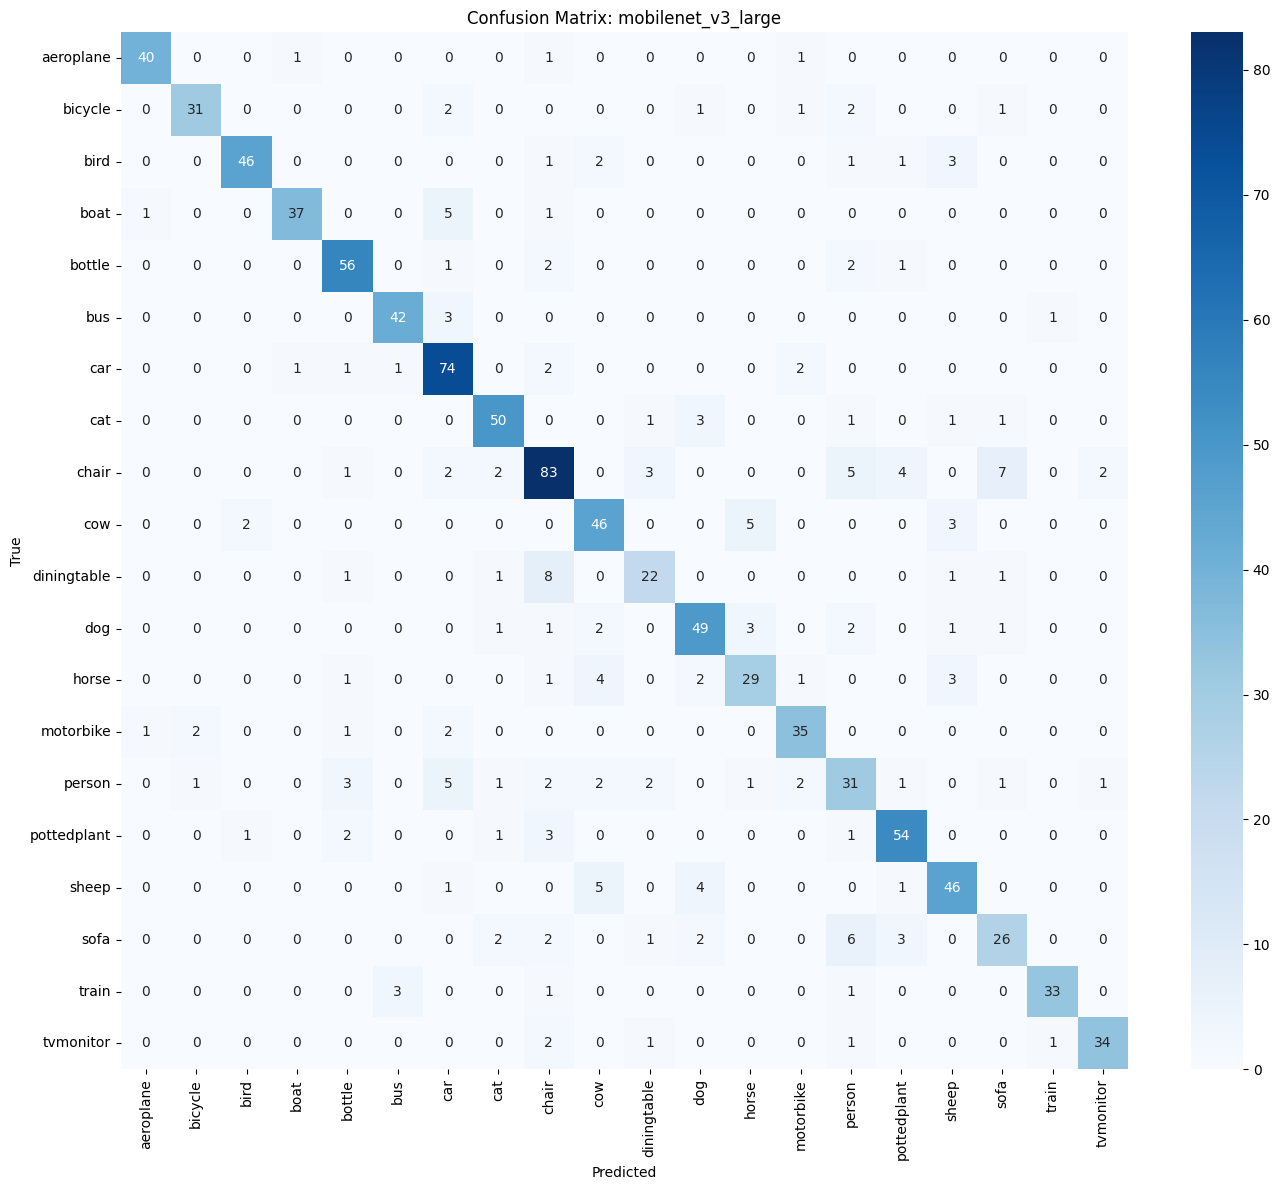

0.8174077578051088

In [57]:
evaluate_model(
    "mobilenet_v3_large",
    len(class_names),
    class_names,
    test_loader,
    device,
    checkpoint_path="best_mobilenet_v3_large_headonly_sgd.pth"
)
